# Intro
In this notebook we'll develop a LSTM for predictive maintenance on FD004 to predict the Remaining Useful Life (RUL) of the engines. FD004 is characterized by the engines running on different operating conditions and developing one of two possible faults.(see metadata below). You can find a full explanation of the code in my accompanying blogpost [here](https://towardsdatascience.com/lstm-for-predictive-maintenance-of-turbofan-engines-f8c7791353f3?sk=b2bd1590168a6eaab5d13857807afbda)  

Data Set: FD004  
Train trjectories: 248  
Test trajectories: 249  
Conditions: SIX  
Fault Modes: TWO (HPC Degradation, Fan Degradation)  

<disclaimer: I aim to showcase the effect of different methods and choices made during model development. These effects are often shown using the test set, something which is considered (very) bad practice but helps for educational purposes.>

In [1]:
%matplotlib inline
import os
seed = 42
os.environ['PYTHONHASHSEED']=str(seed)

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [2]:
!git clone https://github.com/edwardzjl/CMAPSSData.git

Cloning into 'CMAPSSData'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16 (from 1)
Receiving objects: 100% (16/16), 11.96 MiB | 18.53 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed

2025-04-12 16:00:19.522205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744473619.730953      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744473619.789703      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# important: set random seeds to get reproducible results

Initial weights of neural networks are generated randomly. Due to this randomness results may vary, making it very difficult to judge whether the changes you make are because of this randomness or actuall improvements to model performance. Therefore we wan't to control the random initialization to allow comparing between iterations.

#### Find a more thorough explanation on getting reproducible results [here](https://towardsdatascience.com/primer-on-developing-reproducible-neural-networks-in-jupyter-notebook-2f88d23b7c8d?sk=dbb8d4efdc36aa676cb97857b946c5ca)

In [4]:
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
dir_path = '/kaggle/working/CMAPSSData/'
train_file = 'train_FD004.txt'
test_file = 'test_FD004.txt'


In [6]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names
train = pd.read_csv((dir_path+train_file), sep='\s+', header=None,
                 names=col_names)
test = pd.read_csv((dir_path+test_file), sep='\s+', header=None,
                 names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD004.txt'), sep='\s+', header=None,
                 names=['RemainingUsefulLife'])

def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()

    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)

    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life

    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

X_train = train[setting_names + sensor_names].copy()
y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=125)

X_test = test.drop('time_cycles', axis=1).groupby('unit_nr').last().copy() # get last row of each engine

# Baseline model

In [7]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [8]:
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.437942286412216, R2:0.7220738975061536
test set RMSE:34.593735911370004, R2:0.5974472412019296


# Plotting

In [9]:
# before we start plotting, lets implement the condition specific scaling
def add_operating_condition(df):
    df_op_cond = df.copy()

    df_op_cond['setting_1'] = df_op_cond['setting_1'].round()
    df_op_cond['setting_2'] = df_op_cond['setting_2'].round(decimals=2)

    # converting settings to string and concatanating makes the operating condition into a categorical variable
    df_op_cond['op_cond'] = df_op_cond['setting_1'].astype(str) + '_' + \
                        df_op_cond['setting_2'].astype(str) + '_' + \
                        df_op_cond['setting_3'].astype(str)

    return df_op_cond

def condition_scaler(df_train, df_test, sensor_names):
    # apply operating condition specific scaling
    scaler = StandardScaler()
    for condition in df_train['op_cond'].unique():
        scaler.fit(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
        df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
    return df_train, df_test

In [10]:
X_train_condition = add_operating_condition(train)
X_test_condition = add_operating_condition(X_test)

X_train_condition_scaled, X_test_condition_scaled = condition_scaler(X_train_condition, X_test_condition, sensor_names)

/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.27462144 -0.32737159 -0.92936463  1.47860752 -0.92936463 -0.92936463
  0.27462144  0.87661448 -0.32737159  0.87661448 -2.73534374  1.47860752
 -0.92936463  0.87661448 -1.53135767  0.87661448 -0.92936463  0.87661448
 -0.92936463 -0.32737159 -0.92936463  1.47860752  0.27462144  1.47860752
  0.27462144  0.87661448 -0.92936463  0.87661448  0.27462144  2.0806005

In [11]:
def plot_signal(df, signal_name, unit_nr=None):
    plt.figure(figsize=(13,5))

    if unit_nr:
        plt.plot('RUL', signal_name,
                data=df[df['unit_nr']==unit_nr])
    else:
        for i in train['unit_nr'].unique():
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name,
                         data=df[df['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.show()

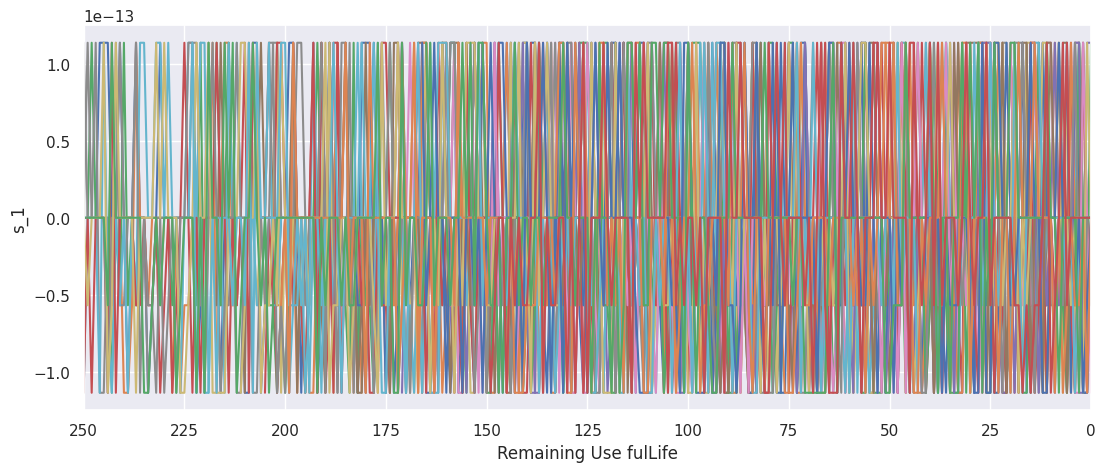

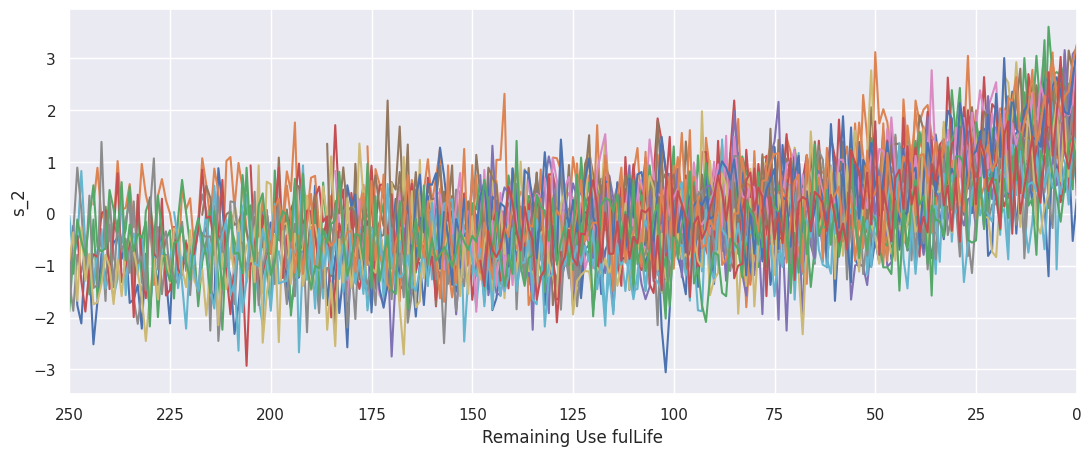

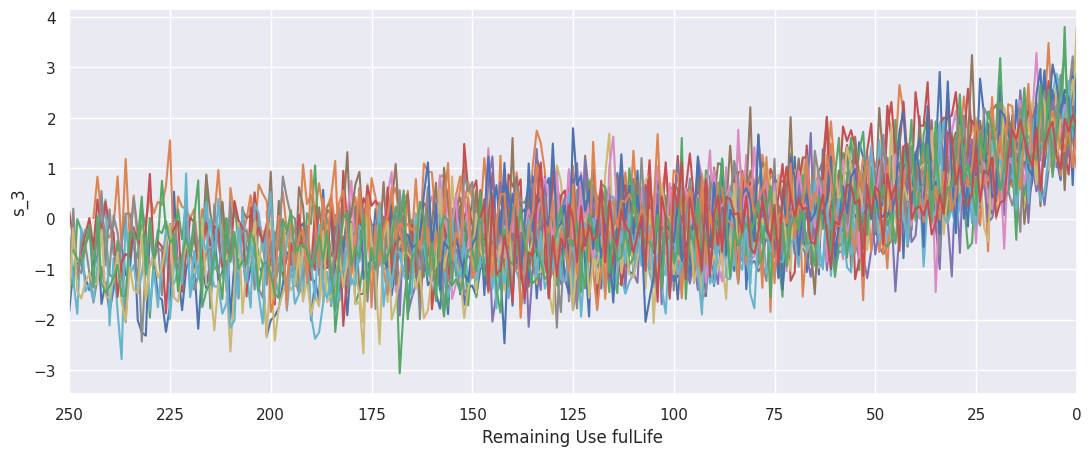

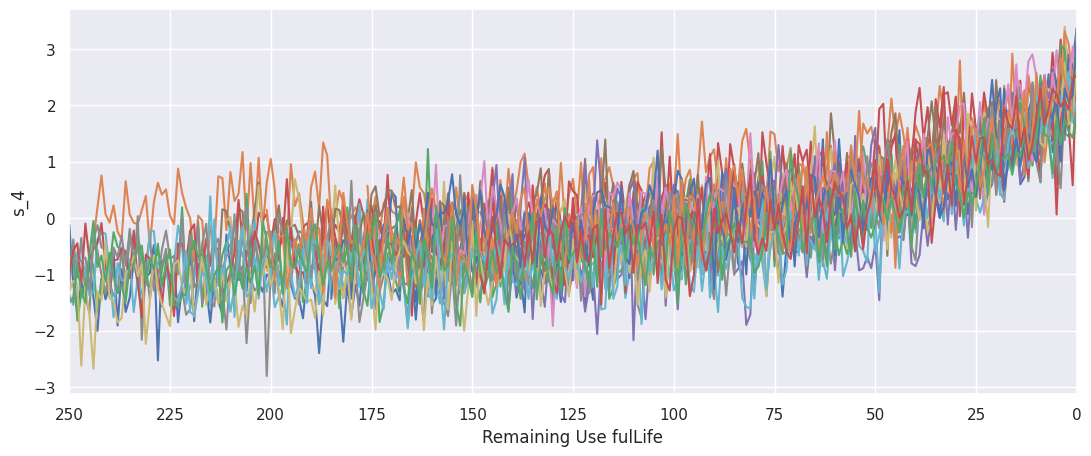

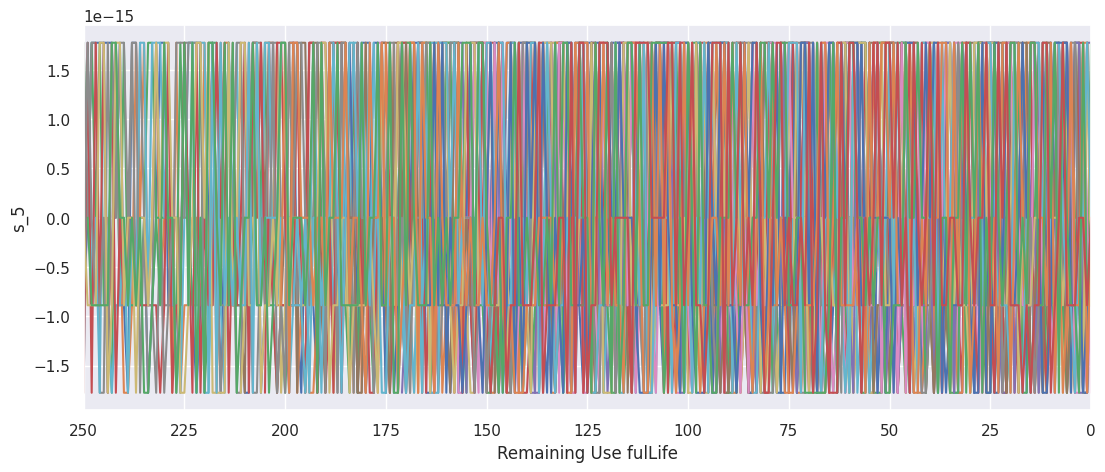

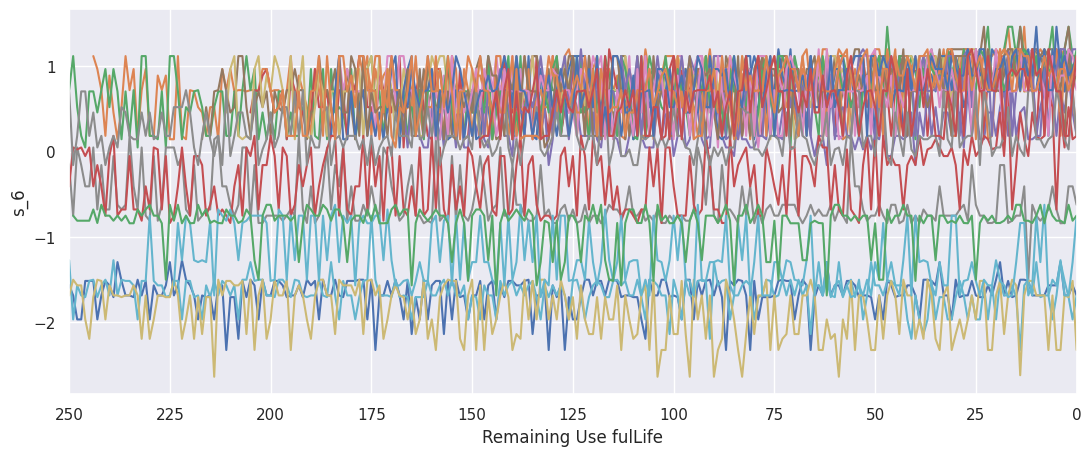

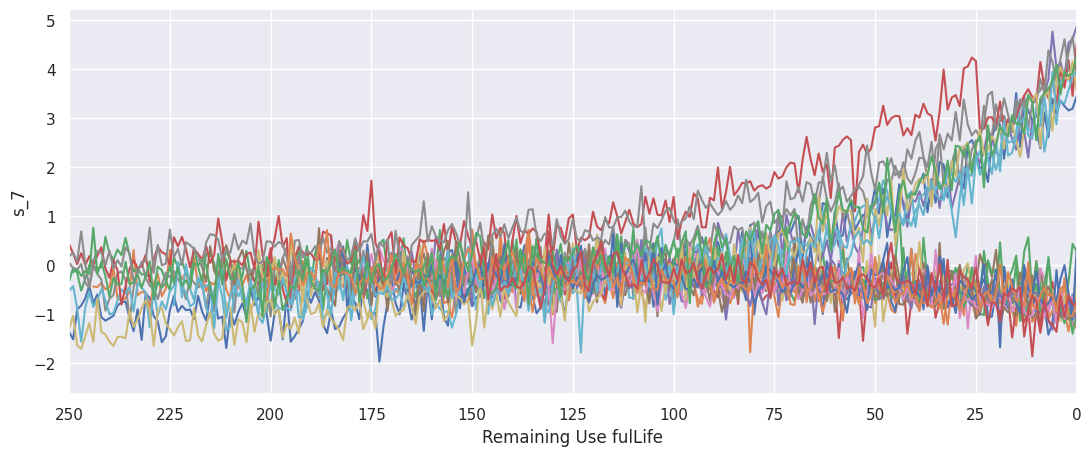

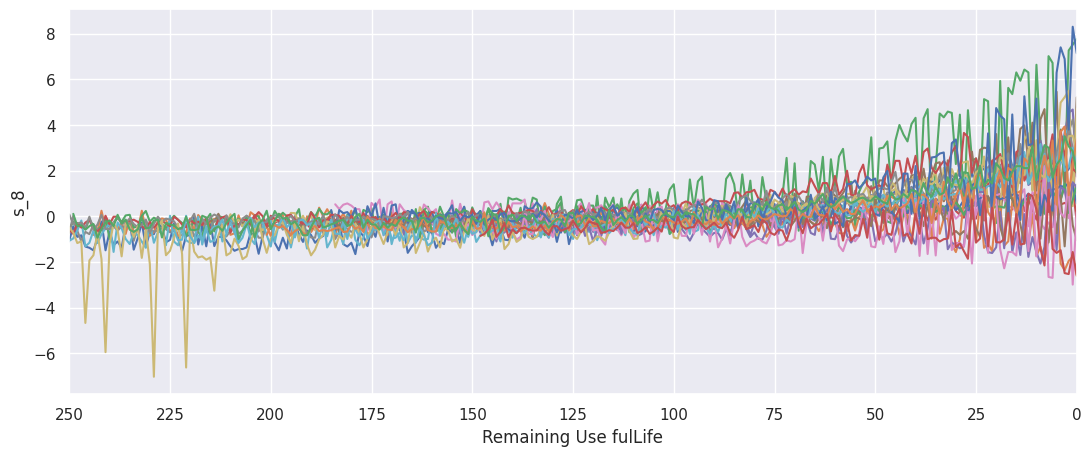

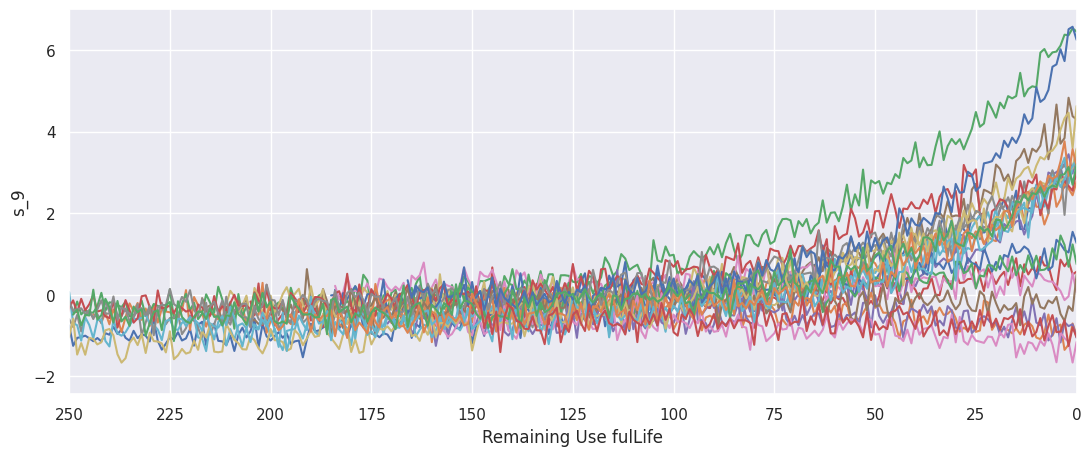

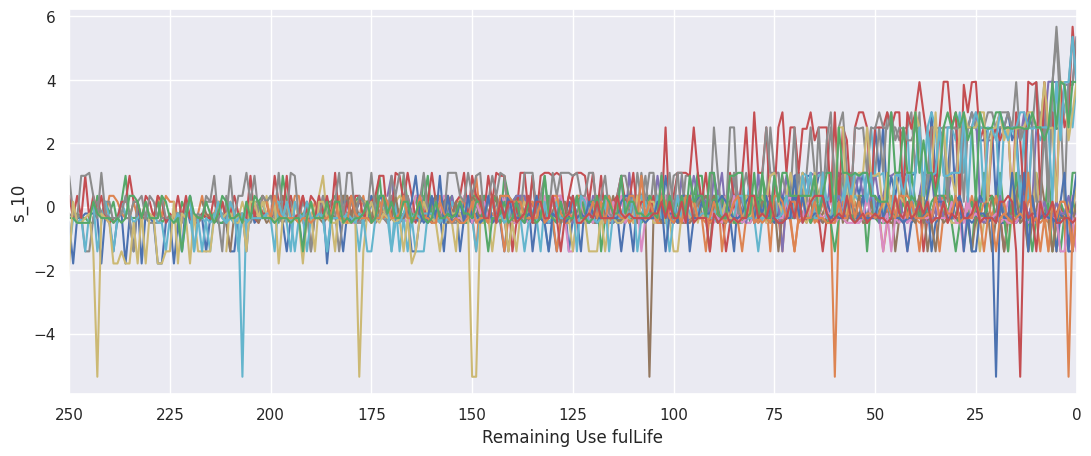

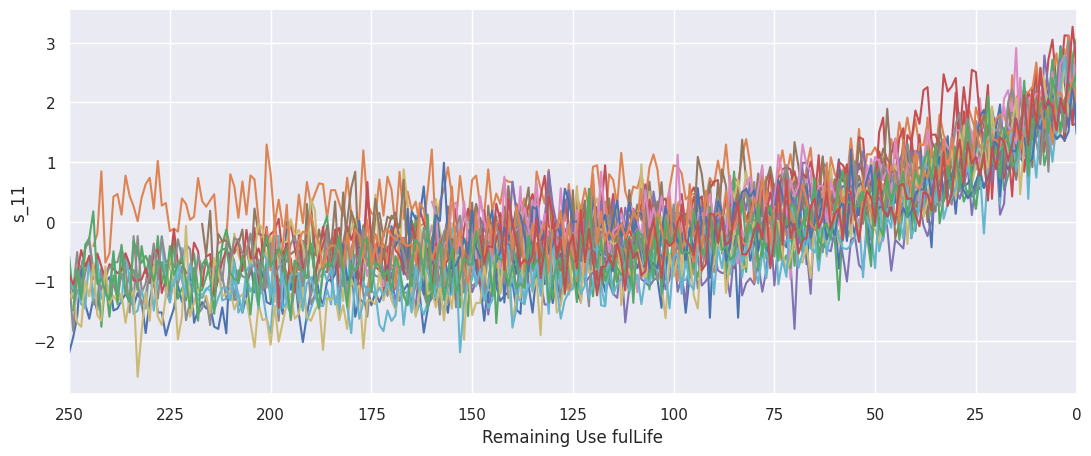

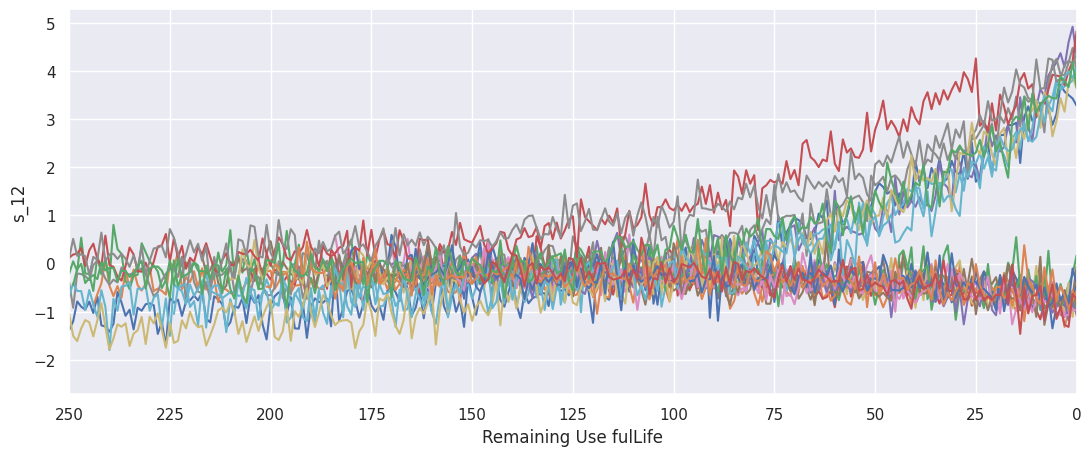

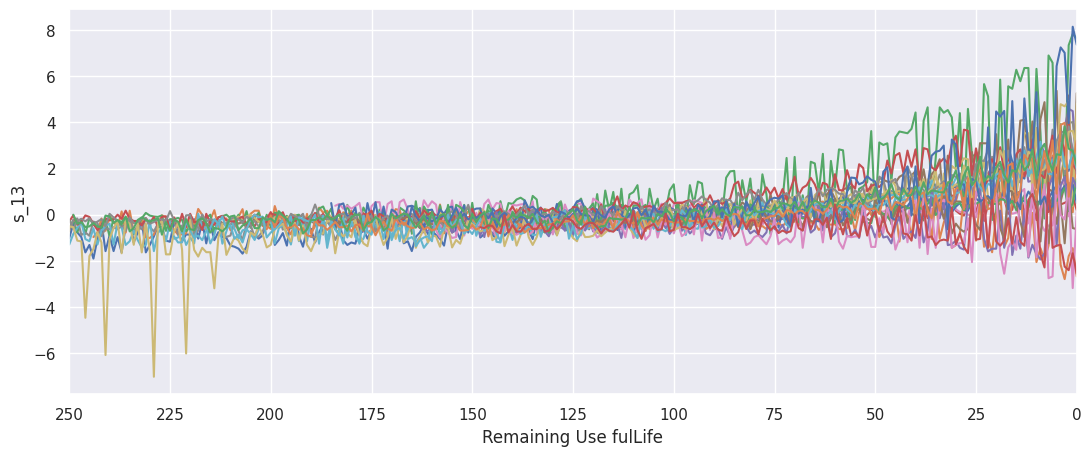

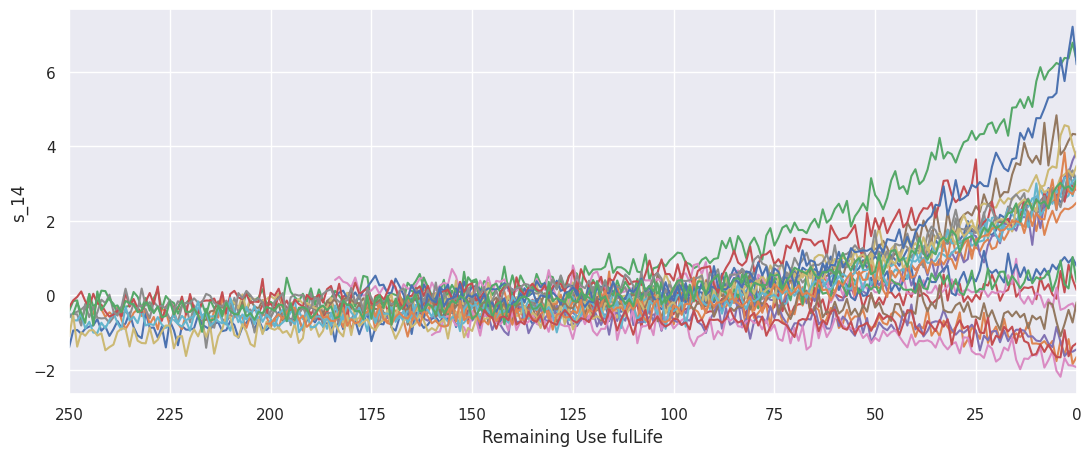

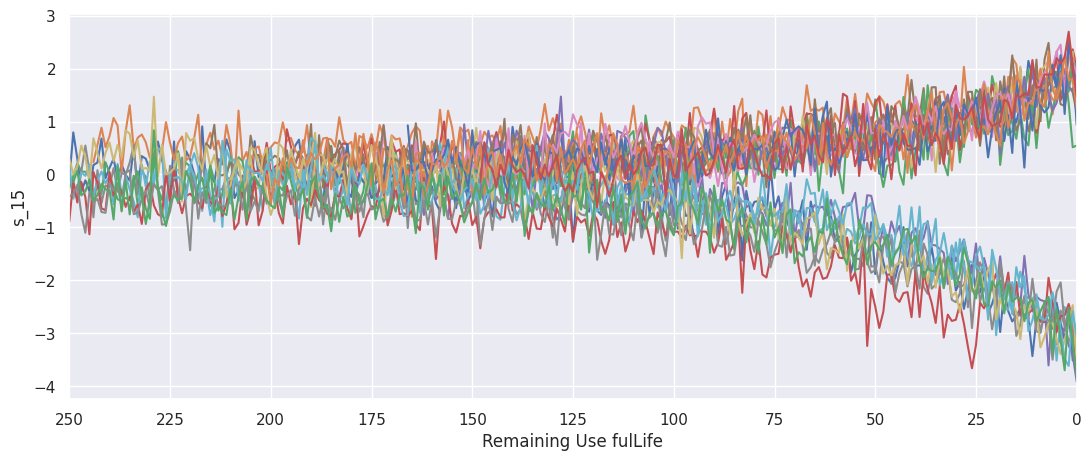

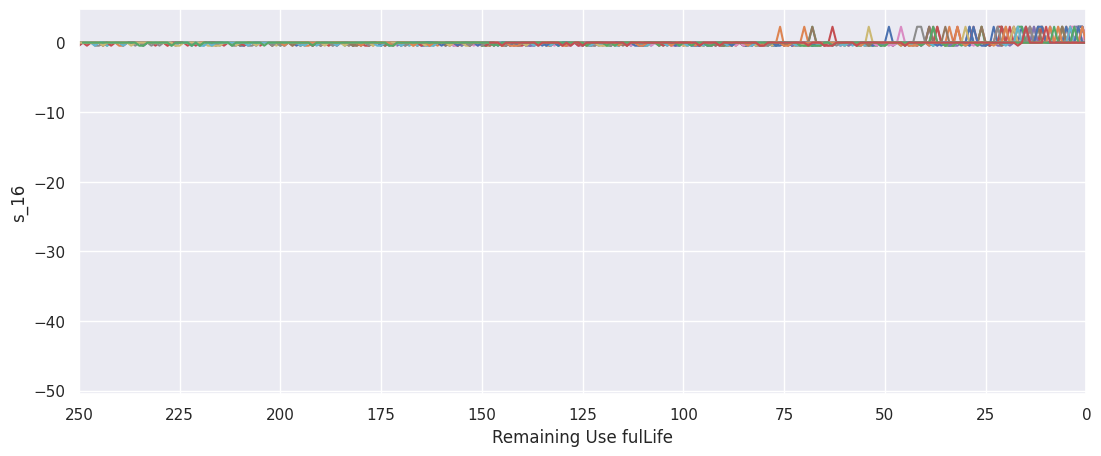

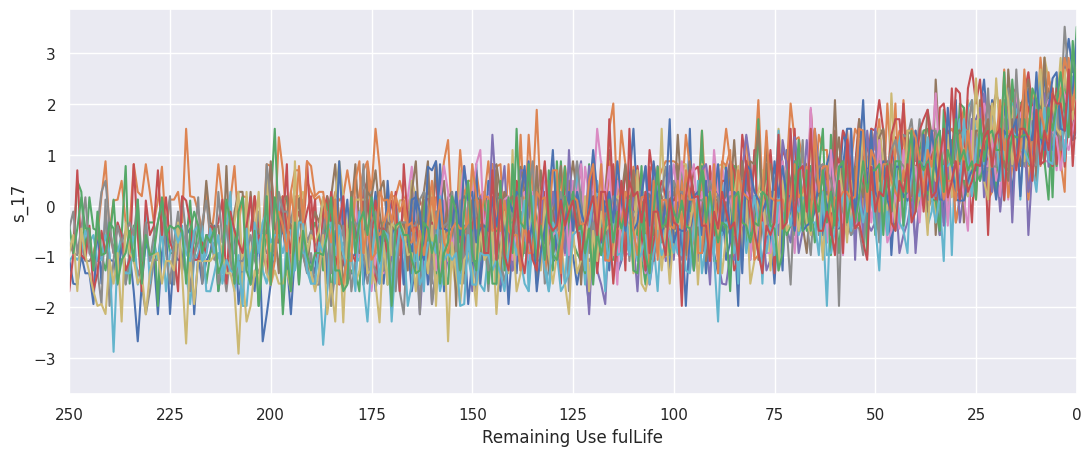

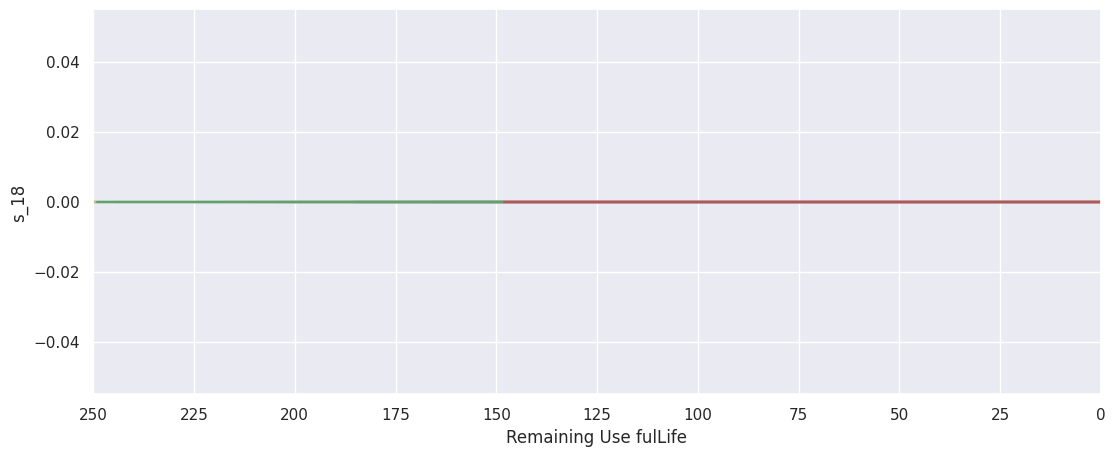

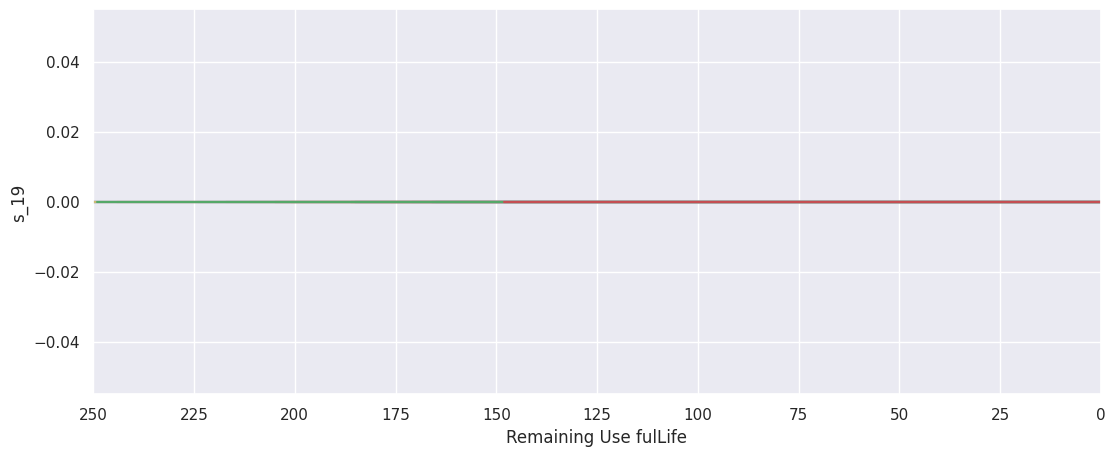

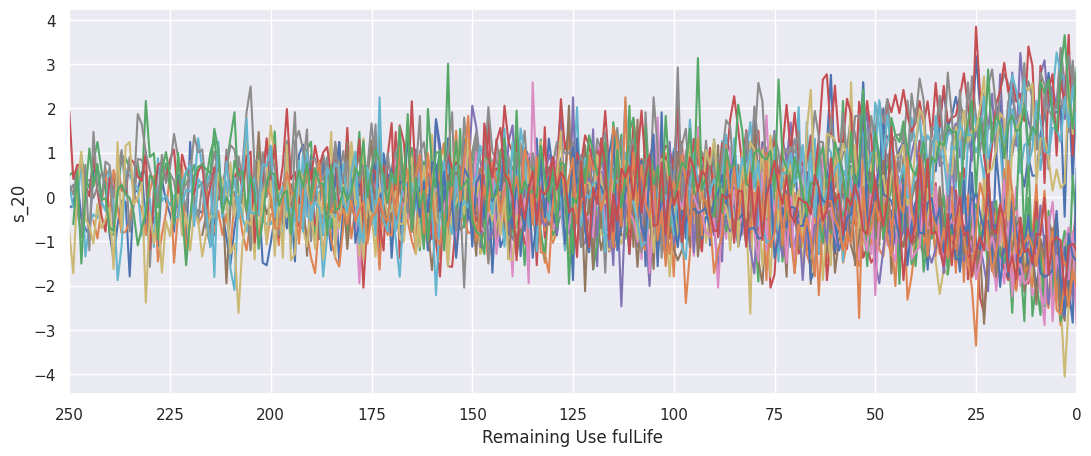

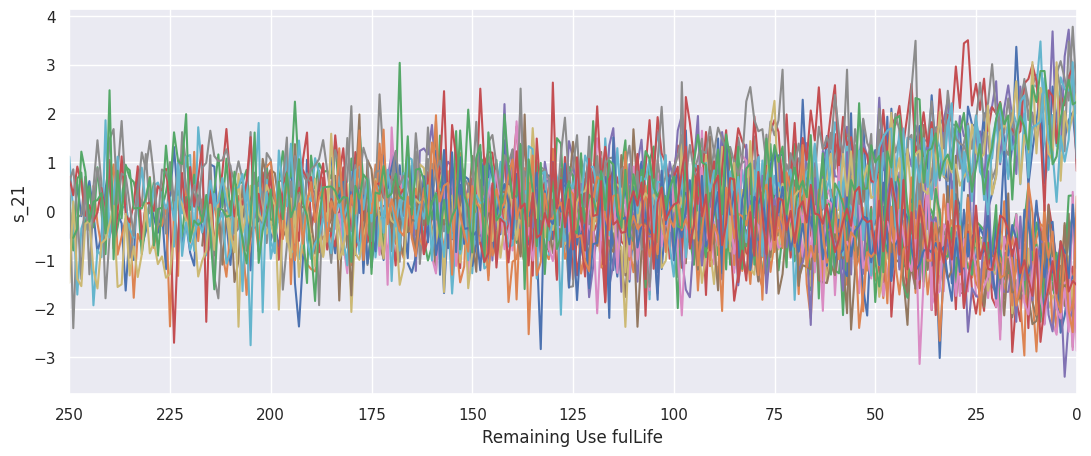

In [12]:
for sensor in sensor_names:
    plot_signal(X_train_condition_scaled, sensor)

Note, useable sensors seem to be ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21'], however sensors ['s_8', 's_9', 's_13', 's_14'] might confuse the model as they don't seem to distinguish between the two fault modes very well. Something we'll have to test during model development

In [13]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

# Data preparation
We can reuse some of the functions from last time, like exponential_smoothing and train_val_group_split

In [14]:
def exponential_smoothing(df, sensors, n_samples, alpha=0.4):
    df = df.copy()
    # first, take the exponential weighted mean
    df[sensors] = df.groupby('unit_nr')[sensors].apply(lambda x: x.ewm(alpha=alpha).mean())

    # second, drop first n_samples of each unit_nr to reduce filter delay
    def create_mask(data, samples):
        result = np.ones_like(data)
        result[0:samples] = 0
        return result

    mask = df.groupby('unit_nr')['unit_nr'].transform(create_mask, samples=n_samples).astype(bool)
    df = df[mask]

    return df

In [15]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  # eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, groups, print_groups=True):

    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique())
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split

## Sequences

In [16]:
d = {'unit_nr': [1]*5 + [2]*5,
     'X': [10., 10.2, 10.4, 10.6, 10.8, 20., 20.2, 20.4, 20.6, 20.8],
     'y': [1.4, 1.4, 1.3, 1.2, 1.1, 2.4, 2.4, 2.3, 2.2, 2.1]}
example_df = pd.DataFrame(data=d)
example_df

unit_nr     X    y
0        1  10.0  1.4
1        1  10.2  1.4
2        1  10.4  1.3
3        1  10.6  1.2
4        1  10.8  1.1
5        2  20.0  2.4
6        2  20.2  2.4
7        2  20.4  2.3
8        2  20.6  2.2
9        2  20.8  2.1

code for generating sequences is based on code in Microsoft Azure's github repository [https://github.com/Azure/lstms_for_predictive_maintenance]. However, considerable changes have been made.  
See example_df above, the traditional generator would create a sequence [10., 10.2, 10.4, 10.6] to predict [1.1], where I want the sequence [10., 10.2, 10.4, 10.6, 10.8] to predict [1.1]. The latter is in line with previous implementations throughout the series, plus we can add that tiny bit more information to perform our predictions.  
The original code would not consider engines if the number of records for that engine was lower than the sequence that's being generated, effectively removing part of the test set. I do want to include all test engines, therefore I've implemented padding. see further down below.

In [17]:
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]


In [18]:
gen = gen_train_data(example_df[example_df['unit_nr']==1], sequence_length=4, columns=['X'])
list(gen)

[array([[10. ],
        [10.2],
        [10.4],
        [10.6]]),
 array([[10.2],
        [10.4],
        [10.6],
        [10.8]])]

In [19]:
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    data_gen = (list(gen_train_data(df[df['unit_nr']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [20]:
data_array = gen_data_wrapper(example_df, sequence_length=4, columns=['X'])
data_array

array([[[10. ],
        [10.2],
        [10.4],
        [10.6]],

       [[10.2],
        [10.4],
        [10.6],
        [10.8]],

       [[20. ],
        [20.2],
        [20.4],
        [20.6]],

       [[20.2],
        [20.4],
        [20.6],
        [20.8]]], dtype=float32)

For the labels we'll do something similar

In [21]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['unit_nr'].unique()

    label_gen = [gen_labels(df[df['unit_nr']==unit_nr], sequence_length, label)
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [22]:
label = gen_labels(example_df[example_df['unit_nr']==1], sequence_length=4, label=['y'])
label

array([[1.2],
       [1.1]])

In [23]:
label_array = gen_label_wrapper(example_df, sequence_length=4, label=['y'])
label_array

array([[1.2],
       [1.1],
       [2.2],
       [2.1]], dtype=float32)

In [24]:
# padding example
a = np.full(shape=(5,3), fill_value=-99.)  # desired sequence length
b = np.full(shape=(2,3), fill_value=0.)  # available sequence length

idx = a.shape[0] - b.shape[0]  # equals to 3

a[idx:,:] = b
a

array([[-99., -99., -99.],
       [-99., -99., -99.],
       [-99., -99., -99.],
       [  0.,   0.,   0.],
       [  0.,   0.,   0.]])

In [25]:
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values

    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [26]:
# notice the masked value I passed is a float,
# it should be the same datatype as the data you're working with
gen = (list(gen_test_data(example_df[example_df['unit_nr']==unit_nr], sequence_length=6, columns=['X'], mask_value=-99.))
           for unit_nr in example_df['unit_nr'].unique())
next(gen)

[array([[-99. ],
        [ 10. ],
        [ 10.2],
        [ 10.4],
        [ 10.6],
        [ 10.8]])]

# LSTM

In [27]:
# # test to see if results are better on the first initialization
# remaining_sensors = ['s_2', 's_3', 's_4', 's_7',
#        's_11', 's_12', 's_15', 's_17', 's_20', 's_21']
# drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [28]:
sequence_length = 20
train['RUL'].clip(upper=125, inplace=True)

X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique()):
    train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['unit_nr'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

/tmp/ipykernel_19/1949569506.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=125, inplace=True)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transf

In [29]:
model = Sequential()
model.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model.add(LSTM(32, activation='tanh', use_cudnn=False))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1744473646.221060      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744473646.221736      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [30]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.save_weights('simple_lstm.weights.h5')

In [31]:
!pip install mlflow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00


In [32]:
!pip install pyngrok -q

In [33]:
import tensorflow as tf
import mlflow
import os

class MLflowModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, experiment_name, run_name=None):
        super().__init__()
        self.experiment_name = experiment_name
        self.run_name = run_name
        self.example_input = np.random.random((1, sequence_length, train_array.shape[2]))

    def on_epoch_end(self, epoch, logs=None):
        # Save the model to a temp directory
        model_path = f"temp_model_epoch_{epoch+1}.tf"

        # Log the model to MLflow
        # mlflow.tensorflow.log_model(
        #     model=self.model,
        #     artifact_path=model_path,
        #     input_example=self.example_input,
        # )

        # print(f"✅ Model logged to MLflow at {model_path}")


        # predict and evaluate
        y_hat_val = model.predict(val_split_array)
        evaluate(val_split_label, y_hat_val, 'val')
        mlflow.log_metric('train_rmse', np.sqrt(mean_squared_error(val_split_label, y_hat_val)))
        mlflow.log_metric('train_r2', r2_score(val_split_label, y_hat_val))

        # y_hat_test = model.predict(test_array)
        # evaluate(y_test, y_hat_test)
        # mlflow.log_metric('test_rmse', np.sqrt(mean_squared_error(y_test, y_hat_test)))
        # mlflow.log_metric('test_r2', r2_score(y_test, y_hat_test))



In [34]:
# mlflow.set_tracking_uri("databricks")
# mlflow.create_experiment(
#     "/Users/qazpoigoes@gmail.com/lstm_v1",
#     artifact_location="dbfs:/Volumes/test/tracking/experiments/mlflow-artifacts/",
#     tags={"version": "v1", "priority": "P1"},
# )
local_registry = "sqlite:///mlruns.db"
mlflow.set_tracking_uri(local_registry)


In [35]:
model.compile(loss='mean_squared_error', optimizer='adam')  # the model is recompiled to reset the optimizer
model.load_weights('simple_lstm.weights.h5')  # weights are reloaded to ensure reproducible results

mlflow.set_experiment("/kaggle/working/lstm_v1")

callbacks = [MLflowModelCheckpoint(experiment_name="/kaggle/working/lstm_v1")]

mlflow.autolog(True)

# mlflow.tensorflow.autolog(

# )

with mlflow.start_run() as run:

    params = {
        "epochs": 5,
        "batch_size": 32,
    }

    history = model.fit(train_split_array, train_split_label,
                        validation_data=(val_split_array, val_split_label),
                        callbacks=[callbacks],
                        **params)
    y_hat_train = model.predict(train_array)
    evaluate(label_array, y_hat_train, 'train')
    mlflow.log_metric('train_rmse', np.sqrt(mean_squared_error(label_array, y_hat_train)))
    mlflow.log_metric('train_r2', r2_score(label_array, y_hat_train))

    y_hat_test = model.predict(test_array)
    evaluate(y_test, y_hat_test)
    mlflow.log_metric('test_rmse', np.sqrt(mean_squared_error(y_test, y_hat_test)))
    mlflow.log_metric('test_r2', r2_score(y_test, y_hat_test))



2025/04/12 16:01:07 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/04/12 16:01:07 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

Epoch 1/5


I0000 00:00:1744473674.107453      77 service.cc:148] XLA service 0x2c45f3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744473674.108340      77 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744473674.108363      77 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744473674.440628      77 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1744473675.495920      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025/04/12 16:01:16 INFO mlflow.bedrock: Enabled auto-tracing for Bedrock. Note that MLflow can only trace boto3 service clients that are created after this call. If you have already created one, please recreate the client by calling `boto3.client`.
2025/04/12 16:01:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for boto3.


344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:55.54397964477539, R2:-0.7997355106848485
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - loss: 7140.6016 - val_loss: 3085.1323
Epoch 2/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:32.89006423950195, R2:0.3689494583320957
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 2471.6855 - val_loss: 1081.7563
Epoch 3/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:22.409481048583984, R2:0.7070467335029447
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 828.2851 - val_loss: 502.1849
Epoch 4/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:19.590118408203125, R2:0.7761233117341068
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 355.4937 - val_loss: 383.7729
Epoch 5/5
344/344 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


val set RMSE:19.127620697021484, R2:0.7865694120197553
1423/1423 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 258.2840 - val_loss: 365.8659
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


2025/04/12 16:02:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:210: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`."
2025/04/12 16:02:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1767/1767 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
train set RMSE:15.961309432983398, R2:0.8500849129760126
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
test set RMSE:29.06723735051883, R2:0.7157925946713111


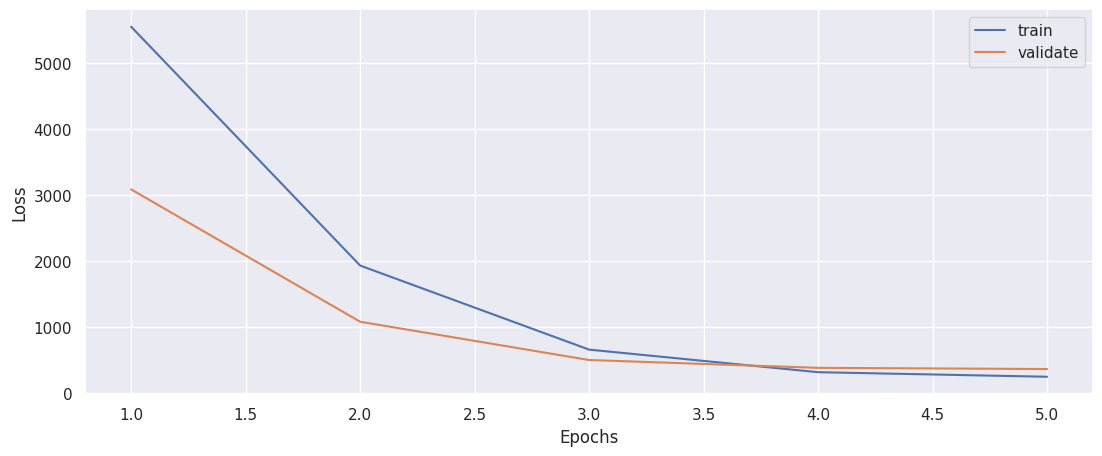

In [36]:
# plot history
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [37]:
get_ipython().system_raw("mlflow ui --backend-store-uri sqlite:///mlruns.db --port 5000 &")# run tracking UI in the background

In [38]:
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
# NGROK_AUTH_TOKEN = getpass('Enter the ngrok authtoken: ')
ngrok.set_auth_token("2TsVFigTBVmW71BgovKSVHvocBZ_2QNgMrR2MeNJFWy7Mgswj")

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://87be-35-232-84-65.ngrok-free.app


# Test Serving

In [39]:
from pathlib import Path
run_id = list(Path('/kaggle/working/mlruns').glob("*/*"))[0].name
run_id

'5453d98389e942029dc23fe9a896e939'

In [40]:
import mlflow
import json
model_uri = f"runs:/{run_id}/model"

# Replace INPUT_EXAMPLE with your own input example to the model
# A valid input example is a data instance suitable for pyfunc prediction
input_data = train_array[:5]

print(input_data.shape)
input_data = json.loads(mlflow.models.convert_input_example_to_serving_input(input_data))
json.dump(input_data, open('/kaggle/working/input.json', 'w'))
# Verify the model with the provided input data using the logged dependencies.
# For more details, refer to:
# https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=None,
    input_path='/kaggle/working/input.json',
    env_manager="local"
)

2025/04/12 16:02:10 INFO mlflow.models.python_api: It is highly recommended to use `uv` as the environment manager for predicting with MLflow models as its performance is significantly better than other environment managers. Run `pip install uv` to install uv. See https://docs.astral.sh/uv/getting-started/installation for other installation methods.


(5, 20, 14)


2025/04/12 16:02:10 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py:210: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
{"predictions": [[122.01746368408203], [121.4853286743164], [121.95552825927734], [122.0793685913086], [122.13117980957031]]}

# Hyperparameter tuning
parameters to tune:
    - alpha, filter strength
    - sequence_length
    - epochs
    - number of layers
    - nodes per layer
    - dropout
    - optimizer, learning rate (I choose to not tune this parameter)
    - activation function
    - batch size
    - included sensors

In [41]:
# I know lower alpha's perform better, so we can ditch a few high ones to reduce the search space
alpha_list = [0.01, 0.05] + list(np.arange(10,60+1,10)/100)

sequence_list = list(np.arange(10,40+1,5))
# epoch_list = list(np.arange(5,20+1,5))
epoch_list = [5,10,15]
nodes_list = [[32], [64], [128], [256], [32, 64], [64, 128], [128, 256]]

# lowest dropout=0.1, because I know zero dropout will yield better training results but worse generalization
dropouts = list(np.arange(1,5)/10)

# again, earlier testing revealed relu performed significantly worse, so I removed it from the options
activation_functions = ['tanh', 'sigmoid']
# batch_size_list = [32, 64, 128, 256]
batch_size_list = [128,256,512]
sensor_list = [['s_2', 's_3', 's_4', 's_7', 's_8', 's_9', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']]

tuning_options = np.prod([len(alpha_list),
                          len(sequence_list),
                          len(epoch_list),
                          len(nodes_list),
                          len(dropouts),
                          len(activation_functions),
                          len(batch_size_list),
                          len(sensor_list)])
tuning_options

28224

In [42]:
train['RUL'].clip(upper=125, inplace=True)

def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    return X_train_interim, X_test_interim

[2025-04-12 16:02:12 +0000] [505] [INFO] Starting gunicorn 23.0.0
[2025-04-12 16:02:12 +0000] [505] [INFO] Listening at: http://127.0.0.1:5000 (505)
[2025-04-12 16:02:12 +0000] [505] [INFO] Using worker: sync
[2025-04-12 16:02:12 +0000] [506] [INFO] Booting worker with pid: 506
[2025-04-12 16:02:12 +0000] [507] [INFO] Booting worker with pid: 507
/tmp/ipykernel_19/116720093.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=125, inplace=True)
[2025-04-12 16:02:12 +0000] [508] [INFO] Booting worker with

In [43]:
# input_shape = (sequence_length, train_array.shape[2])
def create_model(input_shape, nodes_per_layer, dropout, activation, weights_file):
    model = Sequential()
    model.add(Masking(mask_value=-99., input_shape=input_shape))
    if len(nodes_per_layer) <= 1:
        model.add(LSTM(nodes_per_layer[0], activation=activation))
        model.add(Dropout(dropout))
    else:
        model.add(LSTM(nodes_per_layer[0], activation=activation, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(nodes_per_layer[1], activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    model.save_weights(weights_file)
    return model

In [44]:
# random grid search takes significant time, set iterations to a higher number if you truly want to tune parameters
ITERATIONS = 25

In [45]:
%%time
results = pd.DataFrame(columns=['MSE', 'std_MSE', 'alpha', # bigger std means less robust
                                'epochs', 'nodes', 'dropout',
                                'activation', 'batch_size',
                                'sequence_length', 'sensor_length'])

weights_file = 'fd004_model.weights.h5'

res = []

for i in range(ITERATIONS):
    if ITERATIONS < 10:
        print('iteration ', i+1)
    elif ((i+1) % 10 == 0):
        print('iteration ', i+1)

    mse = []

    # init parameters
    alpha = random.sample(alpha_list, 1)[0]
    sequence_length = random.sample(sequence_list, 1)[0]
    epochs = random.sample(epoch_list, 1)[0]
    nodes_per_layer = random.sample(nodes_list, 1)[0]
    dropout = random.sample(dropouts, 1)[0]
    activation = random.sample(activation_functions, 1)[0]
    batch_size = random.sample(batch_size_list, 1)[0]
    remaining_sensors = random.sample(sensor_list, 1)[0]
    drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

    # create model
    input_shape = (sequence_length, len(remaining_sensors))
    model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

    # create train-val split
    X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)
    gss = GroupShuffleSplit(n_splits=3, train_size=0.80, random_state=42)
    for train_unit, val_unit in tqdm(gss.split(X_train_interim['unit_nr'].unique(), groups=X_train_interim['unit_nr'].unique())):
        train_unit = X_train_interim['unit_nr'].unique()[train_unit]  # gss returns indexes and index starts at 1
        train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
        train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)

        val_unit = X_train_interim['unit_nr'].unique()[val_unit]
        val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
        val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

        # train and evaluate model
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.load_weights(weights_file)  # reset optimizer and node weights before every training iteration

        history = model.fit(train_split_array, train_split_label,
                            validation_data=(val_split_array, val_split_label),
                            epochs=epochs,
                            batch_size=batch_size,
                            verbose=1)
        mse.append(history.history['val_loss'][-1])

    # append results
    d = {'MSE':np.mean(mse), 'std_MSE':np.std(mse), 'alpha':alpha,
         'epochs':epochs, 'nodes':str(nodes_per_layer), 'dropout':dropout,
         'activation':activation, 'batch_size':batch_size, 'sequence_length':sequence_length,
         'sensor_length':len(remaining_sensors)}
    res.append(pd.DataFrame(d, index=[0]))

results = pd.concat(res, ignore_index=True)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.2746

Epoch 1/5
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9876.1543

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 9839.5801 - val_loss: 8300.7949
Epoch 2/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8214.7031

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8210.1992 - val_loss: 7479.1538
Epoch 3/5
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7514.7090

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7510.3408 - val_loss: 6951.5474
Epoch 4/5
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6997.1885

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6993.3198 - val_loss: 6486.9009
Epoch 5/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6534.1768

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6531.7939 - val_loss: 6061.4966
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


2025/04/12 16:02:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


1it [00:20, 20.38s/it]2025/04/12 16:02:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'cca38dba69464bd09869d77c84c53421', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9729.6250

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9705.5430 - val_loss: 8596.2559
Epoch 2/5
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8086.8101

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8081.5830 - val_loss: 7785.8232
Epoch 3/5
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7403.2212

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7399.1187 - val_loss: 7247.7666
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6895.4458

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6894.5894 - val_loss: 6772.3291
Epoch 5/5
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6443.1157

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6441.5391 - val_loss: 6336.2290


WARNI [tensorflow] 5 out of the last 1780 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7be4b67e9940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


2025/04/12 16:02:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "
WARNI [tensorflow] 6 out of the last 1781 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7be5cab6fec0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


2it [00:36, 17.92s/it]2025/04/12 16:02:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '19d8a041f862477f941693ddd13b4ce2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9843.7500

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9807.4150 - val_loss: 8405.7959
Epoch 2/5
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8202.2529

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8193.3066 - val_loss: 7591.0732
Epoch 3/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7486.9355

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7484.0649 - val_loss: 7054.2607
Epoch 4/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6972.0425

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6969.4946 - val_loss: 6582.8838
Epoch 5/5
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6510.5659

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6508.2295 - val_loss: 6151.1460
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


2025/04/12 16:03:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


3it [00:52, 17.60s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9099.9912

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 9091.7695 - val_loss: 7142.0054
Epoch 2/10
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7065.7988

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7061.3730 - val_loss: 6272.0889
Epoch 3/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6241.4668

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6232.3940 - val_loss: 5562.1982
Epoch 4/10
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5534.3193

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5531.1001 - val_loss: 4931.9585
Epoch 5/10
85/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4917.1416

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4910.3384 - val_loss: 4392.3037
Epoch 6/10
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4386.9565

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4384.6245 - val_loss: 3927.9023
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3916.6875

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3915.3582 - val_loss: 3416.9719
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3397.1211

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3396.0337 - val_loss: 3005.7317
Epoch 9/10
82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2996.1626

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2988.7881 - val_loss: 2642.8191
Epoch 10/10
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2630.9812

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2627.7024 - val_loss: 2328.9634
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step


2025/04/12 16:03:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


1it [00:22, 22.85s/it]2025/04/12 16:03:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '267aa579c8d84b44ae51a91f317b2da3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9086.8818

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 9077.9189 - val_loss: 7473.9185
Epoch 2/10
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7054.1509

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7045.6558 - val_loss: 6582.9585
Epoch 3/10
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6231.6865

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6224.4854 - val_loss: 5839.4272
Epoch 4/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5521.7368

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5517.5928 - val_loss: 5193.9385
Epoch 5/10
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4926.3657

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4920.7490 - val_loss: 4637.8071
Epoch 6/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4395.6958

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4392.6001 - val_loss: 4154.7090
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3933.2144

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3931.5916 - val_loss: 3646.1648
Epoch 8/10
83/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3427.2607

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3418.9768 - val_loss: 3199.9058
Epoch 9/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3016.9387

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3014.5444 - val_loss: 2826.0723
Epoch 10/10
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2662.1233

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2660.0024 - val_loss: 2490.3613
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step


2025/04/12 16:03:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step


2it [00:45, 22.79s/it]2025/04/12 16:03:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b82bc9a01c87431da48cbb3ff2b79096', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9093.0938

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 9076.2490 - val_loss: 7256.6821
Epoch 2/10
82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7072.8789

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7053.5166 - val_loss: 6376.0122
Epoch 3/10
82/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6234.9048

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6219.2993 - val_loss: 5656.7388
Epoch 4/10
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5530.7456

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5525.7207 - val_loss: 5038.7134
Epoch 5/10
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4940.2676

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4931.2041 - val_loss: 4483.3848
Epoch 6/10
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4389.7954

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4387.2866 - val_loss: 4004.6406
Epoch 7/10
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3919.2666

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3916.3623 - val_loss: 3471.1609
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3397.8186

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3396.6716 - val_loss: 3042.6199
Epoch 9/10
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2991.6882

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2987.7222 - val_loss: 2674.9185
Epoch 10/10
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2640.2727

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2636.6934 - val_loss: 2348.2300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step


2025/04/12 16:04:15 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


3it [01:08, 22.93s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9017.8740

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 9014.7363 - val_loss: 7474.4058
Epoch 2/15
163/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7421.8848

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7405.7988 - val_loss: 6382.0518
Epoch 3/15
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6359.6694

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6347.8218 - val_loss: 5471.7686
Epoch 4/15
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5422.3101

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5413.4697 - val_loss: 4570.0215
Epoch 5/15
160/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4537.4907

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4523.2832 - val_loss: 3850.6924
Epoch 6/15
163/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3828.4832

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3819.4678 - val_loss: 3253.4609
Epoch 7/15
161/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3234.6938

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3225.5823 - val_loss: 2749.9741
Epoch 8/15
163/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2727.0820

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2720.9592 - val_loss: 2326.0273
Epoch 9/15
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2302.6362

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2298.5024 - val_loss: 1970.5093
Epoch 10/15
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1950.5449

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1945.4325 - val_loss: 1671.1899
Epoch 11/15
165/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1645.4360

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1642.5706 - val_loss: 1423.9387
Epoch 12/15
164/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1391.8334

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1389.2103 - val_loss: 1218.8048
Epoch 13/15
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1177.9131

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1174.9033 - val_loss: 1032.8176
Epoch 14/15
167/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 983.8401

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 982.6571 - val_loss: 893.4250
Epoch 15/15
162/171 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 842.0517

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 840.1945 - val_loss: 787.6234
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step


2025/04/12 16:04:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


1it [00:31, 31.82s/it]2025/04/12 16:04:50 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'db2c81f9e9534e9bbe27a919846c7e2a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8926.9551

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 8923.7715 - val_loss: 7875.0947
Epoch 2/15
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7350.3452

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7346.7627 - val_loss: 6762.1021
Epoch 3/15
157/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6332.6357

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6316.0273 - val_loss: 5814.7139
Epoch 4/15
156/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5413.4175

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5395.3188 - val_loss: 4886.7471
Epoch 5/15
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4539.2446

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4534.4204 - val_loss: 4139.3789
Epoch 6/15
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3850.5039

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3847.4302 - val_loss: 3513.7061
Epoch 7/15
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3269.0620

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3264.7471 - val_loss: 2981.6409
Epoch 8/15
157/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2778.9956

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2771.1152 - val_loss: 2528.5989
Epoch 9/15
155/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2360.1655

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2352.2915 - val_loss: 2142.7297
Epoch 10/15
156/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2003.4596

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1997.3308 - val_loss: 1814.9050
Epoch 11/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1699.5830

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1699.1421 - val_loss: 1538.1560
Epoch 12/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1448.6398

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1448.2860 - val_loss: 1306.0874
Epoch 13/15
165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1237.3375

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1236.2932 - val_loss: 1089.3771
Epoch 14/15
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1038.1241

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1036.8600 - val_loss: 921.1475
Epoch 15/15
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 894.7346

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 893.9061 - val_loss: 789.3688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


2025/04/12 16:05:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


2it [01:03, 31.95s/it]2025/04/12 16:05:22 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd17c6d39f0204891ac6fc85860d2c6d3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8919.6133

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 8916.8330 - val_loss: 7614.9971
Epoch 2/15
166/169 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7332.5435

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7326.7798 - val_loss: 6516.7349
Epoch 3/15
159/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6301.0703

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6288.2534 - val_loss: 5584.2549
Epoch 4/15
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5368.3149

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5358.6978 - val_loss: 4671.5840
Epoch 5/15
164/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4503.5020

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4497.8145 - val_loss: 3942.8486
Epoch 6/15
160/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3808.9116

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3801.1179 - val_loss: 3332.8958
Epoch 7/15
161/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3225.8882

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3220.0198 - val_loss: 2816.7400
Epoch 8/15
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2731.2568

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2727.5244 - val_loss: 2379.0793
Epoch 9/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2314.1604

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2311.9170 - val_loss: 2008.4498
Epoch 10/15
164/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1958.4934

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1956.2344 - val_loss: 1695.5270
Epoch 11/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1664.7592

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1663.1931 - val_loss: 1432.7509
Epoch 12/15
159/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1415.7007

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1412.8865 - val_loss: 1211.4827
Epoch 13/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1194.9027

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1193.6974 - val_loss: 1008.2739
Epoch 14/15
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1006.8935

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1005.9727 - val_loss: 856.6265
Epoch 15/15
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 864.7641

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 863.8030 - val_loss: 736.9113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


2025/04/12 16:05:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


3it [01:35, 31.88s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9680.4873

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 9675.9688 - val_loss: 8459.4150
Epoch 2/10
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8519.4043

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8482.9873 - val_loss: 7714.2402
Epoch 3/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7785.9766

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7761.6948 - val_loss: 7080.6509
Epoch 4/10
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7161.1196

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7132.0615 - val_loss: 6493.4868
Epoch 5/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6564.3999

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6543.3853 - val_loss: 5957.5796
Epoch 6/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6028.6377

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6009.2319 - val_loss: 5470.9517
Epoch 7/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5534.0195

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5516.4194 - val_loss: 5022.7710
Epoch 8/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5083.0308

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5067.0327 - val_loss: 4612.3726
Epoch 9/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4671.3989

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4656.2808 - val_loss: 4234.8540
Epoch 10/10
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4293.8169

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4276.9048 - val_loss: 3887.2014
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


2025/04/12 16:06:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


1it [00:23, 23.48s/it]2025/04/12 16:06:17 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e2e6f0bd939f49a6b4259b3088bd1f30', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9589.8408

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 9585.3945 - val_loss: 8813.7900
Epoch 2/10
85/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8420.1289

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8405.2529 - val_loss: 8054.0840
Epoch 3/10
81/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7716.4683

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7695.2612 - val_loss: 7405.0464
Epoch 4/10
84/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7082.6064

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7068.6572 - val_loss: 6796.3857
Epoch 5/10
84/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6496.8003

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6484.3203 - val_loss: 6252.4937
Epoch 6/10
83/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5980.6675

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5967.6021 - val_loss: 5750.7637
Epoch 7/10
86/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5490.5283

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5483.0127 - val_loss: 5285.6567
Epoch 8/10
78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5060.4727

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5042.3633 - val_loss: 4861.3613
Epoch 9/10
78/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4655.4639

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4638.3823 - val_loss: 4469.9736
Epoch 10/10
80/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4274.0020

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4261.1133 - val_loss: 4108.5752
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


2025/04/12 16:06:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


2it [00:45, 22.76s/it]2025/04/12 16:06:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7c673ffa340a4e6fb52b0c7177989be8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9618.1963

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 9614.0469 - val_loss: 8581.5586
Epoch 2/10
79/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8454.6719

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8425.6631 - val_loss: 7830.3970
Epoch 3/10
78/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7735.1504

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7709.0303 - val_loss: 7189.6187
Epoch 4/10
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7090.0859

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7074.6152 - val_loss: 6588.1855
Epoch 5/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6508.7158

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6491.1719 - val_loss: 6049.2109
Epoch 6/10
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5972.3970

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5958.1743 - val_loss: 5557.4897
Epoch 7/10
81/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5494.9243

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5480.3125 - val_loss: 5108.3105
Epoch 8/10
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5052.8037

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5040.4932 - val_loss: 4684.7910
Epoch 9/10
83/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4634.4331

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4624.6470 - val_loss: 4298.6401
Epoch 10/10
82/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4257.7524

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4247.4741 - val_loss: 3944.1162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


2025/04/12 16:07:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


3it [01:08, 22.89s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/15
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8883.0635

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 8881.7617 - val_loss: 7498.8975
Epoch 2/15
323/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7375.8076

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7366.0596 - val_loss: 6293.3994
Epoch 3/15
326/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6195.8174

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6189.8872 - val_loss: 5277.2808
Epoch 4/15
326/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5197.1514

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5191.5874 - val_loss: 4355.3643
Epoch 5/15
325/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4301.1118

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4296.2021 - val_loss: 3623.7979
Epoch 6/15
326/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3586.2844

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3582.7048 - val_loss: 3011.1414
Epoch 7/15
325/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2957.8472

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2953.8972 - val_loss: 2429.9729
Epoch 8/15
325/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2403.8862

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2400.9648 - val_loss: 1990.5920
Epoch 9/15
322/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1978.2180

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1975.0713 - val_loss: 1631.5797
Epoch 10/15
326/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1639.0028

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1637.1754 - val_loss: 1343.0106
Epoch 11/15
326/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1353.0140

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1351.4817 - val_loss: 1115.8834
Epoch 12/15
326/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1122.7914

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1121.5646 - val_loss: 933.4641
Epoch 13/15
329/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 938.7962

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 938.2192 - val_loss: 786.6579
Epoch 14/15
322/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 803.5361

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 802.0288 - val_loss: 664.8658
Epoch 15/15
323/333 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 671.8425

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


333/333 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 671.0004 - val_loss: 582.6135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


2025/04/12 16:07:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


1it [00:42, 42.40s/it]2025/04/12 16:07:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0537df2f72154672a4e722b881539841', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8773.1064

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 8771.8350 - val_loss: 7910.8877
Epoch 2/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7282.6968

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7281.0166 - val_loss: 6666.8940
Epoch 3/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6127.2905

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6125.9014 - val_loss: 5625.8345
Epoch 4/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5160.3589

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5159.0293 - val_loss: 4670.1421
Epoch 5/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4292.1177

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4291.0811 - val_loss: 3905.6060
Epoch 6/15
319/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3594.8413

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3590.8403 - val_loss: 3232.0178
Epoch 7/15
322/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2961.3125

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2958.9111 - val_loss: 2636.4343
Epoch 8/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2437.7739

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2437.1218 - val_loss: 2167.6997
Epoch 9/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2006.9794

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2006.4963 - val_loss: 1778.2448
Epoch 10/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1668.1116

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1667.6990 - val_loss: 1460.2091
Epoch 11/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1386.7821

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1386.4501 - val_loss: 1203.8757
Epoch 12/15
326/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1157.2153

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1156.9720 - val_loss: 988.4926
Epoch 13/15
324/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 980.0267

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 979.6544 - val_loss: 825.6747
Epoch 14/15
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 845.2798

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 845.0596 - val_loss: 678.7124
Epoch 15/15
325/327 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 727.6816

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 727.4527 - val_loss: 549.8455
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


2025/04/12 16:08:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


2it [01:25, 42.62s/it]2025/04/12 16:08:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7915502ad59b4933a4e84067e613272e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8876.6641

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 8875.2881 - val_loss: 7632.5205
Epoch 2/15
329/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7362.7383

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7359.9189 - val_loss: 6409.8364
Epoch 3/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6191.0474

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6186.3081 - val_loss: 5386.9482
Epoch 4/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5200.9326

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5196.5352 - val_loss: 4447.2100
Epoch 5/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4315.7666

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4312.2544 - val_loss: 3702.1875
Epoch 6/15
324/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3600.5281

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3596.8494 - val_loss: 3078.4438
Epoch 7/15
325/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2997.6780

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2994.3774 - val_loss: 2480.7744
Epoch 8/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2435.6765

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2433.6111 - val_loss: 2020.7888
Epoch 9/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2006.7906

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2005.0889 - val_loss: 1647.2084
Epoch 10/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1667.0752

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1665.6371 - val_loss: 1341.1005
Epoch 11/15
325/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1375.5242

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1374.2502 - val_loss: 1094.9297
Epoch 12/15
321/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1155.3320

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1153.5823 - val_loss: 899.6575
Epoch 13/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 969.4775

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 968.6849 - val_loss: 736.9553
Epoch 14/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 822.0799

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 821.3163 - val_loss: 586.9768
Epoch 15/15
326/331 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 671.7447

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


331/331 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 671.3279 - val_loss: 489.5716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


2025/04/12 16:09:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step


3it [02:07, 42.40s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
74/82 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8621.4678

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8554.7324 - val_loss: 6824.3047
Epoch 2/10
76/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6760.1108

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6746.9531 - val_loss: 6010.2383
Epoch 3/10
76/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5980.5107

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5970.0425 - val_loss: 5331.3940
Epoch 4/10
76/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5297.7881

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5288.3179 - val_loss: 4722.7368
Epoch 5/10
75/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4698.5469

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4689.4097 - val_loss: 4195.8105
Epoch 6/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4169.2964

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4165.2344 - val_loss: 3728.3582
Epoch 7/10
79/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3709.7827

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3706.1445 - val_loss: 3314.9219
Epoch 8/10
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3299.1069

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3294.1885 - val_loss: 2949.8574
Epoch 9/10
77/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2935.3142

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2930.9795 - val_loss: 2624.4551
Epoch 10/10
78/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2602.0759

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2598.8420 - val_loss: 2331.9861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


2025/04/12 16:09:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


1it [00:20, 20.20s/it]2025/04/12 16:09:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '76cfa717c2a94057a8edef865aa9f26d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8529.4316

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 8498.0615 - val_loss: 7230.7007
Epoch 2/10
75/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6722.8716

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6709.1294 - val_loss: 6400.4692
Epoch 3/10
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5966.3364

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5951.6064 - val_loss: 5717.4727
Epoch 4/10
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5325.3896

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5312.5679 - val_loss: 5114.3018
Epoch 5/10
73/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4755.0430

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4743.6460 - val_loss: 4573.6963
Epoch 6/10
75/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4246.8306

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4239.2871 - val_loss: 4092.5234
Epoch 7/10
79/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3791.8240

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3789.6079 - val_loss: 3657.4744
Epoch 8/10
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3396.0417

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3391.8318 - val_loss: 3268.9734
Epoch 9/10
78/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3030.8816

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3028.2036 - val_loss: 2919.2393
Epoch 10/10
77/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2709.8765

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2706.5400 - val_loss: 2609.6277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


2025/04/12 16:09:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2it [00:41, 20.71s/it]2025/04/12 16:09:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2a00fa01bcb1452db494896c7c0ce51d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8633.4824

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 8592.4453 - val_loss: 6963.7788
Epoch 2/10
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6791.4238

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6783.8052 - val_loss: 6147.7427
Epoch 3/10
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6025.3052

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6014.7188 - val_loss: 5478.6226
Epoch 4/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5368.3242

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5364.7368 - val_loss: 4887.3276
Epoch 5/10
77/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4794.7476

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4786.5039 - val_loss: 4356.2915
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4271.4966

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4270.0947 - val_loss: 3885.8286
Epoch 7/10
78/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3814.1504

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3809.1030 - val_loss: 3466.1040
Epoch 8/10
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3411.2234

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3404.2666 - val_loss: 3091.1396
Epoch 9/10
80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3042.5112

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3040.4602 - val_loss: 2754.0439
Epoch 10/10
76/81 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2711.3521

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2705.9031 - val_loss: 2452.6501
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


2025/04/12 16:10:10 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


3it [01:01, 20.44s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9044.9932

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 9042.7393 - val_loss: 6686.3330
Epoch 2/5
355/372 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6344.9185

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6320.8555 - val_loss: 4773.2573
Epoch 3/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4502.8481

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4501.8823 - val_loss: 3388.4929
Epoch 4/5
367/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3192.0039

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3187.7925 - val_loss: 2392.3376
Epoch 5/5
354/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2249.6223

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2239.9888 - val_loss: 1686.0181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


2025/04/12 16:10:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


1it [00:23, 23.53s/it]2025/04/12 16:10:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '81dc9e5a7e5a4fd7a5cd79dccc491a8d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8926.8545

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 8924.7031 - val_loss: 6999.0249
Epoch 2/5
360/365 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6270.7837

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6263.2700 - val_loss: 5034.3916
Epoch 3/5
363/365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4490.0171

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4487.2769 - val_loss: 3598.8188
Epoch 4/5
351/365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3211.3303

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3201.2556 - val_loss: 2552.7151
Epoch 5/5
352/365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2276.5598

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2269.2268 - val_loss: 1751.0768
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


2025/04/12 16:10:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


2it [00:47, 23.88s/it]2025/04/12 16:11:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '332355a7543f43aeb2e2378bff85238c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9017.3477

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 9015.0967 - val_loss: 6805.5273
Epoch 2/5
362/369 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6333.0171

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6322.1870 - val_loss: 4867.7300
Epoch 3/5
352/369 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4534.5674

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4516.7251 - val_loss: 3459.4575
Epoch 4/5
368/369 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3215.9583

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3214.5422 - val_loss: 2439.1687
Epoch 5/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2253.6284

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2253.0754 - val_loss: 1655.6343
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


2025/04/12 16:11:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


3it [01:11, 23.81s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
343/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5249.8018

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5217.8599 - val_loss: 1345.6041
Epoch 2/10
341/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 895.8609

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 890.2963 - val_loss: 442.9851
Epoch 3/10
342/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 349.2679

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 348.7974 - val_loss: 404.7181
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 272.7631

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 272.7246 - val_loss: 350.9437
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 240.8897

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 240.8723 - val_loss: 339.5516
Epoch 6/10
343/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 226.0139

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 225.9543 - val_loss: 321.6224
Epoch 7/10
342/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 216.8342

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 216.7803 - val_loss: 315.3503
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 209.5542

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 209.5508 - val_loss: 309.6983
Epoch 9/10
339/348 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 205.9459

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 205.9091 - val_loss: 306.4211
Epoch 10/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 200.8013 - val_loss: 307.9311
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


2025/04/12 16:11:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


1it [00:36, 36.67s/it]2025/04/12 16:12:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3abbaa0312e94033be6e7c755cf633ea', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
338/342 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5232.7476

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 5207.8696 - val_loss: 1843.2640
Epoch 2/10
335/342 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1101.3608

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1094.2079 - val_loss: 423.1463
Epoch 3/10
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 425.0080

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 424.6354 - val_loss: 316.4545
Epoch 4/10
339/342 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 360.0974

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 359.8993 - val_loss: 273.9152
Epoch 5/10
334/342 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 313.0844

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 312.6680 - val_loss: 242.5240
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 278.6398 - val_loss: 246.3423
Epoch 7/10
341/342 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 263.2686

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 263.2141 - val_loss: 240.9220
Epoch 8/10
338/342 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 260.1168

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 259.9413 - val_loss: 223.0358
Epoch 9/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 243.4759 - val_loss: 224.5325
Epoch 10/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 246.3380 - val_loss: 240.1357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


2025/04/12 16:12:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


2it [01:13, 37.02s/it]2025/04/12 16:12:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '21811896c9774a45ac3e1a89ac1eb78a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
345/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5197.9502

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 5188.2798 - val_loss: 1816.0243
Epoch 2/10
338/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1457.7310

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1446.7826 - val_loss: 457.2420
Epoch 3/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 410.4251

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 410.3329 - val_loss: 366.3169
Epoch 4/10
341/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 330.4059

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 330.1819 - val_loss: 320.9709
Epoch 5/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 290.4175

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 290.3901 - val_loss: 256.5502
Epoch 6/10
343/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 268.8666

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 268.7850 - val_loss: 246.0121
Epoch 7/10
337/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 253.6830

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 253.5020 - val_loss: 235.3926
Epoch 8/10
345/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 244.4059

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 244.3718 - val_loss: 226.7012
Epoch 9/10
339/346 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 237.5354

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 237.4032 - val_loss: 224.3432
Epoch 10/10
346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 233.4580 - val_loss: 235.1932
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


2025/04/12 16:13:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


3it [01:50, 36.82s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
176/182 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6638.3096

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6570.6504 - val_loss: 2735.2864
Epoch 2/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2448.0852

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2445.0168 - val_loss: 1775.1523
Epoch 3/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1738.8975

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1737.9092 - val_loss: 1263.7078
Epoch 4/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 832.6855

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 830.5015 - val_loss: 490.1335
Epoch 5/10
179/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 399.4605

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 399.0375 - val_loss: 415.4756
Epoch 6/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 345.0112

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 344.9750 - val_loss: 406.5059
Epoch 7/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 318.4654

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 318.4554 - val_loss: 393.6169
Epoch 8/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 303.1548 - val_loss: 399.8026
Epoch 9/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 298.8796

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 298.9034 - val_loss: 387.6261
Epoch 10/10
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 292.6765

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 292.7002 - val_loss: 382.5162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step


2025/04/12 16:13:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


1it [00:26, 26.52s/it]2025/04/12 16:13:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7a557a307fe14cc7af1ea7af1cc3ed59', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
172/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6623.4351

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6545.6743 - val_loss: 2904.7019
Epoch 2/10
172/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2469.7783

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2457.4709 - val_loss: 1816.7760
Epoch 3/10
172/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1731.2141

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1725.1501 - val_loss: 880.9656
Epoch 4/10
178/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 705.1603

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 703.9105 - val_loss: 418.1402
Epoch 5/10
171/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 437.5358

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 436.2176 - val_loss: 357.0187
Epoch 6/10
172/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 368.0163

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 367.5464 - val_loss: 329.6932
Epoch 7/10
172/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 344.7265

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 344.3578 - val_loss: 326.2690
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 332.2450 - val_loss: 337.0501
Epoch 9/10
172/179 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 324.6866

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 324.3864 - val_loss: 309.5835
Epoch 10/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 317.2965 - val_loss: 313.1190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


2025/04/12 16:14:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


2it [00:52, 26.45s/it]2025/04/12 16:14:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd97f31f981c443ac8dfc2f872055cd31', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
178/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6585.2720

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6547.1230 - val_loss: 2793.3706
Epoch 2/10
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2438.2053

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2433.7722 - val_loss: 1786.2050
Epoch 3/10
172/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1741.9175

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1738.2310 - val_loss: 1362.1230
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 943.3953

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 942.0973 - val_loss: 447.0139
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 431.0784

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 430.9691 - val_loss: 367.8214
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 365.9120

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 365.8840 - val_loss: 326.7898
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 339.5658

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 339.5572 - val_loss: 316.7090
Epoch 8/10
173/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 325.2731

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 325.2344 - val_loss: 309.7037
Epoch 9/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 317.2514

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 317.2697 - val_loss: 304.3422
Epoch 10/10
179/181 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 312.2464

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 312.2754 - val_loss: 300.2917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


2025/04/12 16:14:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


3it [01:20, 26.80s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


iteration  10


/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
0it [00:00, ?it/s]2025/04/12 16:14:36 INFO mlflow.utils.auto

Epoch 1/15
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9866.0859

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9821.0342 - val_loss: 8347.5850
Epoch 2/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8310.9834

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8298.6514 - val_loss: 7605.6636
Epoch 3/15
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7647.5220

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7643.1001 - val_loss: 7080.5498
Epoch 4/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7125.4048

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7122.8311 - val_loss: 6614.0010
Epoch 5/15
89/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6665.9385

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6659.9668 - val_loss: 6185.6802
Epoch 6/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6239.0581

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6232.4614 - val_loss: 5789.6909
Epoch 7/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5843.5527

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5841.4727 - val_loss: 5420.7236
Epoch 8/15
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5471.3032

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5467.3379 - val_loss: 5074.8799
Epoch 9/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5120.6094

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5118.7905 - val_loss: 4750.7690
Epoch 10/15
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4800.2383

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4794.4180 - val_loss: 4446.0601
Epoch 11/15
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4488.5562

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4485.3203 - val_loss: 4160.6973
Epoch 12/15
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4204.0435

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4200.9604 - val_loss: 3892.3533
Epoch 13/15
87/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3935.7400

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3930.5569 - val_loss: 3639.8564
Epoch 14/15
83/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3681.3423

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3673.9360 - val_loss: 3401.1697
Epoch 15/15
86/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3439.3599

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3434.4543 - val_loss: 3177.5168
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


2025/04/12 16:14:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


1it [00:21, 21.47s/it]2025/04/12 16:14:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '72c386d0f19a44699e94c033740f59d5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9724.2910

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9688.5723 - val_loss: 8657.3916
Epoch 2/15
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8178.8599

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8175.7915 - val_loss: 7917.9531
Epoch 3/15
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7531.4990

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7527.4971 - val_loss: 7381.3608
Epoch 4/15
86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7032.4424

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7025.9717 - val_loss: 6904.0840
Epoch 5/15
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6575.2568

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6572.0098 - val_loss: 6464.6997
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6159.0684

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6158.3442 - val_loss: 6058.1372
Epoch 7/15
84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5771.5889

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5765.0703 - val_loss: 5677.8506
Epoch 8/15
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5404.5234

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5401.9155 - val_loss: 5322.2114
Epoch 9/15
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5065.7480

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5064.5981 - val_loss: 4988.3203
Epoch 10/15
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4753.0698

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4751.2725 - val_loss: 4672.9053
Epoch 11/15
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4444.6792

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4443.6445 - val_loss: 4376.8120
Epoch 12/15
89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4161.8765

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4159.9980 - val_loss: 4097.5459
Epoch 13/15
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3901.8225

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3900.8579 - val_loss: 3834.9941
Epoch 14/15
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3650.8547

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3649.9468 - val_loss: 3585.8098
Epoch 15/15
90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3416.3350

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3415.0566 - val_loss: 3351.5542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step


2025/04/12 16:15:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


2it [00:42, 21.45s/it]2025/04/12 16:15:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'deac1470242c477ea46af043478ee649', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9832.4707

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 9786.7822 - val_loss: 8437.9180
Epoch 2/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8264.7549

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8252.7500 - val_loss: 7708.3311
Epoch 3/15
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7611.0771

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7606.7578 - val_loss: 7178.6777
Epoch 4/15
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7105.3296

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7091.9526 - val_loss: 6706.8843
Epoch 5/15
85/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6642.6328

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6631.6597 - val_loss: 6272.7144
Epoch 6/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6215.3862

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6208.5840 - val_loss: 5870.8730
Epoch 7/15
92/93 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5815.3325

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5813.2744 - val_loss: 5496.2754
Epoch 8/15
84/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5458.0405

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5447.5654 - val_loss: 5145.9429
Epoch 9/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5102.6406

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5097.2075 - val_loss: 4816.0103
Epoch 10/15
91/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4777.6851

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4775.0708 - val_loss: 4505.4956
Epoch 11/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4480.0029

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4474.8965 - val_loss: 4214.5938
Epoch 12/15
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4192.2402

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4189.0820 - val_loss: 3940.4553
Epoch 13/15
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3917.5588

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3914.5740 - val_loss: 3681.7681
Epoch 14/15
90/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3668.7600

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3665.9802 - val_loss: 3439.3352
Epoch 15/15
88/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3428.5835

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3424.6929 - val_loss: 3210.7385
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


2025/04/12 16:15:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


3it [01:05, 21.85s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/5
348/356 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8766.0957

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8744.4717 - val_loss: 6520.3345
Epoch 2/5
347/356 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6287.0615

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6276.9653 - val_loss: 5059.2471
Epoch 3/5
351/356 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4894.0005

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4889.3389 - val_loss: 3927.6150
Epoch 4/5
353/356 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3803.5989

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3801.1716 - val_loss: 3038.8066
Epoch 5/5
351/356 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2964.0591

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


356/356 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2961.1377 - val_loss: 2343.9170
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


2025/04/12 16:16:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


1it [00:22, 22.78s/it]2025/04/12 16:16:05 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3f850fd2ed2548d1ad1642ed155ee6fb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
340/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8764.6133

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8736.1562 - val_loss: 6852.5605
Epoch 2/5
339/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6299.1499

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6285.6099 - val_loss: 5351.8564
Epoch 3/5
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4916.9062

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4916.0356 - val_loss: 4183.5405
Epoch 4/5
347/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3858.7002

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3855.8662 - val_loss: 3256.8950
Epoch 5/5
339/350 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3009.7686

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3003.1765 - val_loss: 2519.8555
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


2025/04/12 16:16:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


2it [00:45, 22.67s/it]2025/04/12 16:16:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'bf9f6c40029b42cea7ed4f5850cdd5af', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
344/354 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8760.9209

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 8734.1758 - val_loss: 6643.3784
Epoch 2/5
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6278.6416

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6277.6157 - val_loss: 5158.3838
Epoch 3/5
347/354 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4909.0708

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4902.6475 - val_loss: 4009.0576
Epoch 4/5
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3820.2339

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3816.4802 - val_loss: 3096.7437
Epoch 5/5
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2981.3140

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2978.3411 - val_loss: 2378.5774
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


2025/04/12 16:16:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


3it [01:08, 22.73s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9412.4736

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 9409.7393 - val_loss: 7974.6025
Epoch 2/15
177/186 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7874.7261

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7859.7148 - val_loss: 6894.7231
Epoch 3/15
172/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6839.7769

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6820.6768 - val_loss: 5963.9292
Epoch 4/15
176/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5908.9849

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5896.8257 - val_loss: 5164.3638
Epoch 5/15
176/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5126.6807

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5116.4209 - val_loss: 4491.2344
Epoch 6/15
174/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4456.9141

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4444.9150 - val_loss: 3839.0161
Epoch 7/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3793.9172

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3793.1577 - val_loss: 3290.7979
Epoch 8/15
176/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3261.0969

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3253.6516 - val_loss: 2817.3984
Epoch 9/15
175/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2790.0134

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2782.8599 - val_loss: 2406.5171
Epoch 10/15
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2378.3005

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2377.2993 - val_loss: 2054.2502
Epoch 11/15
173/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2030.8956

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2024.9757 - val_loss: 1755.6798
Epoch 12/15
174/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1741.1766

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1736.1471 - val_loss: 1502.3328
Epoch 13/15
185/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1482.4636

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1481.8041 - val_loss: 1289.7705
Epoch 14/15
176/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1261.0168

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1258.1350 - val_loss: 1109.3428
Epoch 15/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1070.3315

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1070.1345 - val_loss: 955.0777
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step


2025/04/12 16:17:26 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


1it [00:36, 36.99s/it]2025/04/12 16:17:28 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e63ab02235f84be580d6a33a323dc28d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 9279.7822

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - loss: 9277.2920 - val_loss: 8302.9912
Epoch 2/15
176/183 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7766.2378

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7756.0278 - val_loss: 7209.0059
Epoch 3/15
171/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6758.8101

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6744.7896 - val_loss: 6270.8467
Epoch 4/15
181/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5852.6865

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5849.8486 - val_loss: 5441.2754
Epoch 5/15
170/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5099.1929

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5087.5972 - val_loss: 4746.7490
Epoch 6/15
182/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4438.5400

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4436.9663 - val_loss: 4072.4478
Epoch 7/15
173/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3803.8911

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3796.3721 - val_loss: 3496.8293
Epoch 8/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3263.0425

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3262.4841 - val_loss: 2999.5066
Epoch 9/15
170/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2810.0273

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2802.4731 - val_loss: 2566.9915
Epoch 10/15
171/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2404.7236

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2398.9802 - val_loss: 2191.6841
Epoch 11/15
170/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2060.2114

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2054.7605 - val_loss: 1868.8054
Epoch 12/15
172/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1763.8351

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1760.1423 - val_loss: 1592.9600
Epoch 13/15
170/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1512.3680

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1508.4037 - val_loss: 1360.2241
Epoch 14/15
170/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1297.3380

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1294.1351 - val_loss: 1160.4351
Epoch 15/15
169/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1117.1095

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1114.3054 - val_loss: 991.2662
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


2025/04/12 16:18:03 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


2it [01:13, 36.77s/it]2025/04/12 16:18:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'dd36d5c6043d40d180569115e5bdea83', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 9381.3994

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - loss: 9378.6777 - val_loss: 8092.5918
Epoch 2/15
182/185 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7843.8159

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7837.8545 - val_loss: 7008.3682
Epoch 3/15
171/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6823.6489

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6804.2700 - val_loss: 6071.6108
Epoch 4/15
171/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5911.1865

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5893.8618 - val_loss: 5262.4868
Epoch 5/15
171/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5131.8159

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5117.1152 - val_loss: 4582.6992
Epoch 6/15
184/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4459.6377

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4457.7803 - val_loss: 3919.7104
Epoch 7/15
183/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3813.8418

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3811.4580 - val_loss: 3354.8994
Epoch 8/15
171/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3279.4868

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3269.0896 - val_loss: 2868.5972
Epoch 9/15
183/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2809.3445

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2807.5559 - val_loss: 2446.7112
Epoch 10/15
181/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2401.0076

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2398.4456 - val_loss: 2082.5840
Epoch 11/15
170/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2056.0093

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2048.8555 - val_loss: 1770.7980
Epoch 12/15
171/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1755.1603

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1749.4634 - val_loss: 1505.4905
Epoch 13/15
173/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1500.8580

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1496.6903 - val_loss: 1280.4718
Epoch 14/15
171/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1290.0425

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1285.7994 - val_loss: 1091.7057
Epoch 15/15
176/185 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1102.3262

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


185/185 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1100.1812 - val_loss: 933.7061
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step


2025/04/12 16:18:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


3it [01:49, 36.35s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9192.9902

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 9191.7295 - val_loss: 7701.8862
Epoch 2/5
335/348 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7508.4038

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7496.3687 - val_loss: 6356.5747
Epoch 3/5
337/348 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6207.9141

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6199.7544 - val_loss: 5277.3682
Epoch 4/5
348/348 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5157.0049

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5156.4751 - val_loss: 4388.5991
Epoch 5/5
336/348 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4301.6802

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4295.6401 - val_loss: 3642.4358
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


2025/04/12 16:19:05 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


1it [00:26, 26.37s/it]2025/04/12 16:19:07 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2dbef67597ae435fa6be49b1ada13a2b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9129.4883

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 9128.1611 - val_loss: 8085.8984
Epoch 2/5
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7453.3628

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7452.4443 - val_loss: 6703.9189
Epoch 3/5
337/342 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6195.1362

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6190.6743 - val_loss: 5596.6777
Epoch 4/5
336/342 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5169.4902

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5165.2114 - val_loss: 4675.6099
Epoch 5/5
337/342 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4319.7607

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


342/342 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4316.7124 - val_loss: 3895.5928
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


2025/04/12 16:19:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


2it [00:51, 25.53s/it]2025/04/12 16:19:32 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '15d55ba91d4a457e955b43bcb17a601b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9149.5166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 9148.2998 - val_loss: 7837.7876
Epoch 2/5
345/346 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7459.4688

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7457.8477 - val_loss: 6470.2373
Epoch 3/5
337/346 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6179.2148

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6172.8130 - val_loss: 5380.7251
Epoch 4/5
331/346 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5148.1118

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5139.8486 - val_loss: 4477.3550
Epoch 5/5
337/346 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4296.0771

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4291.7251 - val_loss: 3715.9805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


2025/04/12 16:19:55 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


3it [01:16, 25.44s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6400.5469

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 6396.5576 - val_loss: 3062.9058
Epoch 2/15
323/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2698.5215

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2695.7258 - val_loss: 1905.5640
Epoch 3/15
324/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1860.1465

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1859.8776 - val_loss: 1756.0173
Epoch 4/15
323/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1327.7819

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1324.0750 - val_loss: 544.2732
Epoch 5/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 423.4118

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 423.2564 - val_loss: 373.2677
Epoch 6/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 267.7825

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 267.7299 - val_loss: 312.8878
Epoch 7/15
323/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 220.2343

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 220.1681 - val_loss: 290.0369
Epoch 8/15
322/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 202.5274

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 202.4677 - val_loss: 280.3442
Epoch 9/15
324/325 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 191.0734

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 191.0548 - val_loss: 274.4362
Epoch 10/15
323/325 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 182.4659

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 182.4453 - val_loss: 269.3374
Epoch 11/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 178.4628

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 178.4564 - val_loss: 269.3300
Epoch 12/15
324/325 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 175.6738

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 175.6613 - val_loss: 265.1557
Epoch 13/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 173.3934 - val_loss: 267.7042
Epoch 14/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 169.9574 - val_loss: 267.8606
Epoch 15/15
325/325 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 169.9398 - val_loss: 267.5235
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step


2025/04/12 16:21:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step


1it [01:54, 114.28s/it]2025/04/12 16:21:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5b63eb0aee9e4a7f843af5538ff7caac', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6367.7109

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 6363.6709 - val_loss: 3315.3970
Epoch 2/15
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2732.2266

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2729.2502 - val_loss: 1987.9108
Epoch 3/15
316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1876.9110

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1876.2858 - val_loss: 1757.0537
Epoch 4/15
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1440.4374

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1437.9050 - val_loss: 554.8928
Epoch 5/15
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 470.7854

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 470.2470 - val_loss: 369.4448
Epoch 6/15
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 295.8731

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 295.7419 - val_loss: 273.2864
Epoch 7/15
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 238.2217

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 238.1644 - val_loss: 236.9172
Epoch 8/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 222.1609 - val_loss: 237.4288
Epoch 9/15
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 208.9621

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 208.9481 - val_loss: 202.6320
Epoch 10/15
316/319 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 204.1502

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 204.1284 - val_loss: 191.3758
Epoch 11/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 195.5462 - val_loss: 195.8392
Epoch 12/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 191.8451 - val_loss: 200.9455
Epoch 13/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 189.0575

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 189.0561 - val_loss: 189.1461
Epoch 14/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 184.5657 - val_loss: 205.0655
Epoch 15/15
319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 184.3754 - val_loss: 193.2674
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step


2025/04/12 16:23:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


2it [03:44, 111.75s/it]2025/04/12 16:23:42 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '409c3851ce23442ab7b8e84f528eb708', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6441.6758

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 6437.5674 - val_loss: 3158.3103
Epoch 2/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2731.2214

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 2730.2192 - val_loss: 1930.6691
Epoch 3/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1869.3704

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1868.8243 - val_loss: 1753.8773
Epoch 4/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1358.6460

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 1356.2490 - val_loss: 517.7769
Epoch 5/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 468.0753

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 467.3631 - val_loss: 330.5436
Epoch 6/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 298.7816

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 298.6532 - val_loss: 247.1039
Epoch 7/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 253.4564

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 253.3932 - val_loss: 219.1186
Epoch 8/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 236.3372

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 236.2294 - val_loss: 198.6992
Epoch 9/15
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 221.3416

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 221.3013 - val_loss: 195.4270
Epoch 10/15
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 215.3525

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 215.3148 - val_loss: 190.8893
Epoch 11/15
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 208.7269

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 208.7010 - val_loss: 184.1830
Epoch 12/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 203.5711

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 203.5180 - val_loss: 182.6405
Epoch 13/15
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 197.6793

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 197.6436 - val_loss: 181.0016
Epoch 14/15
320/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 195.9057

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 195.8578 - val_loss: 179.8672
Epoch 15/15
321/323 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 192.5949

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 192.5633 - val_loss: 177.7509
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step


2025/04/12 16:25:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


3it [05:36, 112.30s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661

Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 8238.0986

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 8229.7910 - val_loss: 6216.8774
Epoch 2/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5950.6445

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5942.2720 - val_loss: 4684.5254
Epoch 3/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4499.6963

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4493.6514 - val_loss: 3591.0222
Epoch 4/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3481.3625

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3477.2808 - val_loss: 2856.0425
Epoch 5/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2793.7881

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2791.1304 - val_loss: 2373.7966
Epoch 6/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2338.3391

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2336.6277 - val_loss: 2065.1545
Epoch 7/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2050.0964

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2049.0928 - val_loss: 1884.5920
Epoch 8/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1887.7710

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1887.2386 - val_loss: 1790.2306
Epoch 9/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1797.0695

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1796.7893 - val_loss: 1743.8870
Epoch 10/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1752.4430

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1752.2627 - val_loss: 1723.4259
Epoch 11/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1733.9504

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1733.8693 - val_loss: 1716.2334
Epoch 12/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1725.3445

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1725.2881 - val_loss: 1709.5991
Epoch 13/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1488.6068

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1481.3557 - val_loss: 733.1089
Epoch 14/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 662.7092

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 661.7324 - val_loss: 581.1774
Epoch 15/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 505.9750

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 505.5214 - val_loss: 513.9340
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step


2025/04/12 16:26:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


1it [00:59, 59.28s/it]2025/04/12 16:26:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f42a1a68bb474b3c91ce79fab931afac', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 8225.8008

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - loss: 8216.8848 - val_loss: 6537.9316
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5955.8398

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5951.2290 - val_loss: 4957.4756
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4512.9155

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4509.5581 - val_loss: 3810.9626
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3500.3342

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3498.0500 - val_loss: 3028.3984
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2814.9478

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2813.3640 - val_loss: 2492.0505
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2355.7268

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2354.7485 - val_loss: 2152.4448
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2071.2441

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2070.6619 - val_loss: 1940.9800
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1901.4775

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1901.1729 - val_loss: 1819.0564
Epoch 9/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1807.6925

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1807.5623 - val_loss: 1750.3038
Epoch 10/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1764.5133

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1764.4456 - val_loss: 1716.1005
Epoch 11/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1737.7548

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1737.7651 - val_loss: 1699.2349
Epoch 12/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1731.0107

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1731.0393 - val_loss: 1690.9314
Epoch 13/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1713.0688

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1712.4362 - val_loss: 1046.0295
Epoch 14/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 860.9362

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 859.9583 - val_loss: 651.6999
Epoch 15/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 609.2217

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 608.8531 - val_loss: 506.8003
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 727ms/step


2025/04/12 16:27:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


2it [01:58, 59.49s/it]2025/04/12 16:27:34 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f90f9a4427984472bc98cd69ddc972e1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 8222.7891

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - loss: 8214.4316 - val_loss: 6324.7241
Epoch 2/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 5945.3867

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5936.8145 - val_loss: 4774.9961
Epoch 3/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 4496.9321

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4490.7646 - val_loss: 3659.9343
Epoch 4/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3476.9675

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3472.8042 - val_loss: 2907.8884
Epoch 5/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2794.2200

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2791.4399 - val_loss: 2410.9556
Epoch 6/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2342.1768

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2340.3447 - val_loss: 2089.1599
Epoch 7/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2058.5166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 2057.3340 - val_loss: 1897.9658
Epoch 8/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1889.4354

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1888.7876 - val_loss: 1792.4829
Epoch 9/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1799.3167

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1798.9690 - val_loss: 1741.5476
Epoch 10/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1756.5714

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1756.3030 - val_loss: 1717.6733
Epoch 11/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1737.7751

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1737.6176 - val_loss: 1707.3228
Epoch 12/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1727.5872

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1727.4268 - val_loss: 1703.5356
Epoch 13/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1695.3528

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1691.3552 - val_loss: 824.8800
Epoch 14/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 759.7147

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 758.3640 - val_loss: 582.3273
Epoch 15/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 562.3240

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 561.7192 - val_loss: 481.4123
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step


2025/04/12 16:28:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step


3it [02:57, 59.22s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7900.2524

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 7896.0010 - val_loss: 5926.9863
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5693.7446

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5691.6499 - val_loss: 4499.6616
Epoch 3/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4350.1250

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4347.1401 - val_loss: 3486.5134
Epoch 4/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3385.2869

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3382.9004 - val_loss: 2621.5752
Epoch 5/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2488.6423

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2486.5894 - val_loss: 1933.8505
Epoch 6/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1838.8147

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1837.3541 - val_loss: 1454.2335
Epoch 7/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1371.6022

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1370.5610 - val_loss: 1114.8632
Epoch 8/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1044.0764

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1043.3362 - val_loss: 880.7796
Epoch 9/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 807.8304

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 807.2341 - val_loss: 701.9158
Epoch 10/10
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 634.0879

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 633.6573 - val_loss: 573.5804
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


2025/04/12 16:29:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


1it [00:45, 45.88s/it]2025/04/12 16:29:19 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '10c3edfa7b2a4779adfe70a49d27604f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7802.8232

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 7798.6177 - val_loss: 6286.2632
Epoch 2/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5643.9551

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5635.5889 - val_loss: 4808.4131
Epoch 3/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4329.1104

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4323.1411 - val_loss: 3743.6584
Epoch 4/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3390.5972

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3386.1025 - val_loss: 2887.6196
Epoch 5/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2539.2095

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2534.7891 - val_loss: 2108.1150
Epoch 6/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1875.2150

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1872.3921 - val_loss: 1580.7827
Epoch 7/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1412.0897

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1410.0706 - val_loss: 1194.3977
Epoch 8/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1085.2821

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1083.8544 - val_loss: 931.1237
Epoch 9/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 853.3500

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 852.4307 - val_loss: 741.6140
Epoch 10/10
161/164 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 689.6056

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


164/164 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 688.9207 - val_loss: 609.9637
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


2025/04/12 16:30:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step


2it [01:29, 44.75s/it]2025/04/12 16:30:03 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e79253e6260b4a54b33c49cf5be295ae', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7893.7441

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - loss: 7889.3687 - val_loss: 6051.8457
Epoch 2/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5710.7666

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 5697.2891 - val_loss: 4606.3149
Epoch 3/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4365.7534

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4356.1626 - val_loss: 3574.7585
Epoch 4/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3410.8076

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3403.8301 - val_loss: 2764.7712
Epoch 5/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2563.0176

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2555.9011 - val_loss: 1979.4655
Epoch 6/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1882.0975

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1877.4264 - val_loss: 1474.5187
Epoch 7/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1415.6047

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1412.1945 - val_loss: 1110.5972
Epoch 8/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1080.1007

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1077.7366 - val_loss: 858.7567
Epoch 9/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 848.9410

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 847.3181 - val_loss: 685.5604
Epoch 10/10
161/166 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 692.2103

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 690.9240 - val_loss: 564.1124
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


2025/04/12 16:30:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


3it [02:15, 45.09s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8081.6396

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 8077.4551 - val_loss: 6028.6440
Epoch 2/10
168/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5742.7949

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5728.4087 - val_loss: 4501.8921
Epoch 3/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4310.9463

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4302.3110 - val_loss: 3431.4373
Epoch 4/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3259.3667

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3251.1213 - val_loss: 2463.1716
Epoch 5/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2324.3933

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2319.0168 - val_loss: 1803.4902
Epoch 6/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1695.2640

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1691.3979 - val_loss: 1335.5753
Epoch 7/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1245.0631

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1242.4564 - val_loss: 1023.9180
Epoch 8/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 933.2551

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 931.5078 - val_loss: 812.2872
Epoch 9/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 727.1854

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 725.8656 - val_loss: 675.1874
Epoch 10/10
169/174 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 585.9961

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 585.1738 - val_loss: 579.1454
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step


2025/04/12 16:31:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


1it [00:40, 40.28s/it]2025/04/12 16:31:29 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '88ce606e8a82422f8caae9e9f9ce5184', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8027.5669

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 8023.2593 - val_loss: 6369.5342
Epoch 2/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5722.1216

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5719.9810 - val_loss: 4793.0020
Epoch 3/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4320.5869

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4316.0107 - val_loss: 3672.3281
Epoch 4/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3308.1943

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3303.9653 - val_loss: 2662.2881
Epoch 5/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2382.0435

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2379.0715 - val_loss: 1945.0320
Epoch 6/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1750.0923

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1747.9645 - val_loss: 1426.6913
Epoch 7/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1303.7849

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1302.2290 - val_loss: 1064.4821
Epoch 8/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 991.7278

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 990.6182 - val_loss: 817.1583
Epoch 9/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 778.8282

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 778.0457 - val_loss: 646.0309
Epoch 10/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 637.5961

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 637.0343 - val_loss: 529.3661
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step


2025/04/12 16:32:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


2it [01:20, 40.14s/it]2025/04/12 16:32:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd2218d1445014337a358621253e5d4e5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 8039.8398

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 8035.7534 - val_loss: 6149.0488
Epoch 2/10
170/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5717.3984

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5709.4346 - val_loss: 4603.9316
Epoch 3/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4301.8896

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4295.0103 - val_loss: 3517.0681
Epoch 4/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3284.8479

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3278.4905 - val_loss: 2533.1025
Epoch 5/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2356.8118

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2352.3376 - val_loss: 1836.4070
Epoch 6/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1724.9092

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1721.7520 - val_loss: 1344.4056
Epoch 7/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1276.8130

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1274.5408 - val_loss: 1005.8416
Epoch 8/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 964.7167

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 963.2019 - val_loss: 779.4670
Epoch 9/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 758.2163

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 757.1176 - val_loss: 628.8312
Epoch 10/10
169/173 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 617.4789

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 616.7465 - val_loss: 522.5438
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step


2025/04/12 16:32:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step


3it [02:02, 40.82s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7349.7705

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7290.6548 - val_loss: 4374.6870
Epoch 2/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4080.8206

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4063.4602 - val_loss: 2944.2104
Epoch 3/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2799.6206

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2790.9771 - val_loss: 2217.9626
Epoch 4/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2151.6279

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2147.3562 - val_loss: 1855.8555
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1820.1562

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1819.6488 - val_loss: 1658.6346
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1551.2419

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1549.2009 - val_loss: 895.4664
Epoch 7/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 784.1639

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 780.1638 - val_loss: 608.1144
Epoch 8/10
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 529.3602

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 527.4022 - val_loss: 497.5678
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 419.6263

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 419.2767 - val_loss: 437.6606
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 344.1373

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 343.9302 - val_loss: 410.7443
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


2025/04/12 16:33:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


1it [00:29, 29.55s/it]2025/04/12 16:33:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '41c24791b3d7463d99f290b02e985ba0', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7306.3984

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7291.9272 - val_loss: 4700.5493
Epoch 2/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4088.6655

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4079.5911 - val_loss: 3166.2207
Epoch 3/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2812.2478

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2807.7427 - val_loss: 2350.0586
Epoch 4/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2163.4683

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2161.1453 - val_loss: 1928.9600
Epoch 5/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1836.6403

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1835.3872 - val_loss: 1698.3027
Epoch 6/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1643.5900

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1642.3264 - val_loss: 1474.1423
Epoch 7/10
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1390.3911

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1386.2075 - val_loss: 996.1753
Epoch 8/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 853.9109

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 851.6932 - val_loss: 596.7321
Epoch 9/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 560.7409

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 560.0812 - val_loss: 472.1444
Epoch 10/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 453.4350

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 453.0353 - val_loss: 398.7244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


2025/04/12 16:33:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step


2it [00:58, 29.45s/it]2025/04/12 16:33:51 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ce342d6e29604168883ecc5d29a00606', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7351.2246

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 7321.3130 - val_loss: 4468.7754
Epoch 2/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4088.0139

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 4074.4658 - val_loss: 3012.2659
Epoch 3/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2812.2769

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2805.1917 - val_loss: 2234.5278
Epoch 4/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2132.4265

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2128.2324 - val_loss: 1778.3855
Epoch 5/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1704.6351

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1700.4539 - val_loss: 1201.2889
Epoch 6/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1122.4286

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1116.9897 - val_loss: 717.8763
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 710.8420

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 710.2761 - val_loss: 542.2461
Epoch 8/10
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 540.9962

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 539.1759 - val_loss: 433.5228
Epoch 9/10
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 443.4124

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 442.5461 - val_loss: 369.9782
Epoch 10/10
80/83 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 374.1814

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 373.4190 - val_loss: 303.5915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


2025/04/12 16:34:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


3it [01:28, 29.47s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/10
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6366.5952

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 6329.3638 - val_loss: 2785.2166
Epoch 2/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2449.3047

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2442.8237 - val_loss: 2333.5457
Epoch 3/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1293.4288

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1288.3184 - val_loss: 686.5364
Epoch 4/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 526.4384

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 525.2093 - val_loss: 675.1646
Epoch 5/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 375.2939

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 375.0840 - val_loss: 550.3909
Epoch 6/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 302.8586 - val_loss: 611.3849
Epoch 7/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 269.1768

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 268.7842 - val_loss: 484.2911
Epoch 8/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 237.7433 - val_loss: 731.7563
Epoch 9/10
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 274.7258 - val_loss: 564.1362
Epoch 10/10
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 246.5847

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 246.1428 - val_loss: 471.2611
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


2025/04/12 16:34:51 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


1it [00:32, 32.04s/it]2025/04/12 16:34:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd701410671a141d4a9fcaa040bf26d47', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
164/167 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6331.3916

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 6293.0107 - val_loss: 2899.1555
Epoch 2/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2330.3198

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2317.1221 - val_loss: 1188.4768
Epoch 3/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 959.7049

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 955.1212 - val_loss: 578.4393
Epoch 4/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 524.5987

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 523.3787 - val_loss: 397.2607
Epoch 5/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 407.5421

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 406.8245 - val_loss: 332.2127
Epoch 6/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 334.7439

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 334.4146 - val_loss: 309.2272
Epoch 7/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 302.6926

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 302.4665 - val_loss: 286.1861
Epoch 8/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 283.2749

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 282.9633 - val_loss: 259.5976
Epoch 9/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 257.7244

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 257.5375 - val_loss: 230.6371
Epoch 10/10
163/167 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 256.8336

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 256.5745 - val_loss: 218.9004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


2025/04/12 16:35:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


2it [01:03, 31.89s/it]2025/04/12 16:35:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8e052d92dc1a492eba60ec62a31f2810', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/10
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6287.7852

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 6260.4321 - val_loss: 2826.8281
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2385.8835

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2383.4287 - val_loss: 1122.9705
Epoch 3/10
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 933.9926

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 932.3171 - val_loss: 542.3215
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 547.8217

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 547.7076 - val_loss: 413.7151
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 396.5898

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 396.4952 - val_loss: 322.0674
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 311.1236

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 311.0746 - val_loss: 277.7318
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 276.6734

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 276.6967 - val_loss: 262.0667
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 254.5571

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 254.5367 - val_loss: 230.6435
Epoch 9/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 231.8773

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 231.8831 - val_loss: 221.7778
Epoch 10/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 226.2939 - val_loss: 222.0249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step


2025/04/12 16:35:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


3it [01:37, 32.60s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


iteration  20


/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
0it [00:00, ?it/s]2025/04/12 16:35:59 INFO mlflow.utils.auto

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7084.5713

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 7070.0103 - val_loss: 4167.3999
Epoch 2/5
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3886.1809

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3873.9409 - val_loss: 2810.0645
Epoch 3/5
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2684.8682

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2678.9255 - val_loss: 2130.6162
Epoch 4/5
82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1884.3273

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1874.5298 - val_loss: 1159.8033
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1039.8347

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1038.5653 - val_loss: 751.7433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step


2025/04/12 16:36:25 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


1it [00:27, 27.13s/it]2025/04/12 16:36:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb7cd333517e495baf00aeb5730411f9', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 7043.4595

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 7013.4932 - val_loss: 4484.8198
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3891.1182

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3887.0181 - val_loss: 3032.5259
Epoch 3/5
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2710.6560

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 2703.9521 - val_loss: 2129.1394
Epoch 4/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1755.3081

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1749.9559 - val_loss: 1208.4536
Epoch 5/5
80/82 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1054.2028

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1050.5933 - val_loss: 781.1089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


2025/04/12 16:36:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


2it [00:54, 27.07s/it]2025/04/12 16:36:53 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '19e1b91ce61c4581bd96c9783cffef17', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 7137.3433

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 7091.7573 - val_loss: 4325.4907
Epoch 2/5
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3956.5732

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 3947.9829 - val_loss: 2927.3108
Epoch 3/5
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2742.9512

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2738.6079 - val_loss: 2206.7114
Epoch 4/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1970.6979

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 1960.5601 - val_loss: 1189.4615
Epoch 5/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1114.7356

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1110.5540 - val_loss: 748.7186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


2025/04/12 16:37:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


3it [01:21, 27.14s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/5
324/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7395.0366

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 7388.9370 - val_loss: 4789.8398
Epoch 2/5
321/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4434.3120

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4427.9819 - val_loss: 3047.3923
Epoch 3/5
319/325 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2800.3643

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2794.4062 - val_loss: 1916.1016
Epoch 4/5
322/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1755.9646

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1753.8245 - val_loss: 1206.9495
Epoch 5/5
321/325 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1104.6459

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


325/325 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1102.9901 - val_loss: 788.9623
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step


2025/04/12 16:37:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


1it [00:30, 30.88s/it]2025/04/12 16:37:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '584b3020548240919ce1920d55014879', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
317/319 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7349.4121

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 7340.0498 - val_loss: 5183.3418
Epoch 2/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4500.2598

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 4498.9893 - val_loss: 3408.3076
Epoch 3/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2919.5166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2918.6277 - val_loss: 2193.0464
Epoch 4/5
318/319 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1885.3972

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1884.2571 - val_loss: 1403.1908
Epoch 5/5
319/319 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1221.4513

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1221.0930 - val_loss: 917.3871
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


2025/04/12 16:38:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


2it [01:00, 29.86s/it]2025/04/12 16:38:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1d4838d4c8db4a6596323a4862334ffd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7438.7915

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 7435.6318 - val_loss: 4968.9434
Epoch 2/5
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4535.8979

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4533.1587 - val_loss: 3203.0005
Epoch 3/5
317/323 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2922.4480

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2916.0283 - val_loss: 2048.3601
Epoch 4/5
319/323 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1868.6165

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1865.6812 - val_loss: 1299.9232
Epoch 5/5
322/323 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1199.7384

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


323/323 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1199.0160 - val_loss: 835.5190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


2025/04/12 16:38:48 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


3it [01:29, 29.68s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/15
88/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7445.0239

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7413.4287 - val_loss: 4189.1260
Epoch 2/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3867.8818

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3851.2290 - val_loss: 2750.8687
Epoch 3/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2606.8376

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2600.9482 - val_loss: 2077.3660
Epoch 4/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2023.9402

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2020.3217 - val_loss: 1783.3464
Epoch 5/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1760.1748

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1758.4019 - val_loss: 1623.2953
Epoch 6/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1458.5692

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1449.8562 - val_loss: 765.5097
Epoch 7/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 654.6211

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 652.1246 - val_loss: 557.1317
Epoch 8/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 466.5956

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 465.3182 - val_loss: 465.0629
Epoch 9/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 378.3541

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 377.8082 - val_loss: 430.2186
Epoch 10/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 328.1309

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 327.6723 - val_loss: 396.3382
Epoch 11/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 304.4140

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 304.2303 - val_loss: 386.7318
Epoch 12/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 284.4749

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 284.2296 - val_loss: 379.3538
Epoch 13/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 271.2678

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 271.1613 - val_loss: 368.1890
Epoch 14/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 262.2440 - val_loss: 368.6152
Epoch 15/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 254.7864

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 254.6806 - val_loss: 360.8650
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


2025/04/12 16:39:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step


1it [00:30, 30.95s/it]2025/04/12 16:39:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ec460e78e3fa4922b7534559718ed46b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7467.1411

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7434.7642 - val_loss: 4483.3296
Epoch 2/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3925.0105

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3916.0613 - val_loss: 2946.1133
Epoch 3/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2661.6365

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2657.2761 - val_loss: 2191.4377
Epoch 4/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2061.1584

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2059.2083 - val_loss: 1838.6144
Epoch 5/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1783.9249

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1783.0688 - val_loss: 1664.1180
Epoch 6/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1602.0089

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1596.2970 - val_loss: 917.2790
Epoch 7/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 776.1173

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 773.3404 - val_loss: 628.4894
Epoch 8/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 535.3921

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 534.2816 - val_loss: 453.5108
Epoch 9/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 431.0860

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 430.5477 - val_loss: 371.7219
Epoch 10/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 374.8224

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 374.6297 - val_loss: 349.6609
Epoch 11/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 337.4374

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 337.3840 - val_loss: 347.6471
Epoch 12/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 317.2938

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 317.3058 - val_loss: 301.9265
Epoch 13/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 303.9693

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 303.9685 - val_loss: 297.7438
Epoch 14/15
86/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 294.3698

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 294.3254 - val_loss: 292.0625
Epoch 15/15
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 285.5726

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 285.5314 - val_loss: 280.0504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


2025/04/12 16:39:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


2it [01:01, 30.79s/it]2025/04/12 16:39:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8f307c660c194a72ba13571d5771be4d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7458.4917

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7411.0415 - val_loss: 4286.3823
Epoch 2/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3880.3750

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3863.3391 - val_loss: 2796.8428
Epoch 3/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2603.0938

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2594.8467 - val_loss: 2084.5574
Epoch 4/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2009.6124

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2005.9541 - val_loss: 1777.9193
Epoch 5/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1752.2662

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1750.2236 - val_loss: 1597.0468
Epoch 6/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1467.7979

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1457.3290 - val_loss: 714.2123
Epoch 7/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 668.3129

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 665.7660 - val_loss: 523.7610
Epoch 8/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 485.0127

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 484.8089 - val_loss: 457.1609
Epoch 9/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 409.1976

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 408.7238 - val_loss: 359.1594
Epoch 10/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 360.0259

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 359.8440 - val_loss: 330.0437
Epoch 11/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 328.2753

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 328.1562 - val_loss: 307.3336
Epoch 12/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 310.3089 - val_loss: 307.3735
Epoch 13/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 296.1196

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 296.1923 - val_loss: 306.4774
Epoch 14/15
86/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 290.7800

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 290.7495 - val_loss: 304.0101
Epoch 15/15
87/89 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 283.6047

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 283.6511 - val_loss: 289.3347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


2025/04/12 16:40:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


3it [01:32, 30.85s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7567.8179

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 7562.0527 - val_loss: 4798.8120
Epoch 2/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4382.3228

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4377.2256 - val_loss: 3027.2974
Epoch 3/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2823.7471

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2821.1704 - val_loss: 2157.5801
Epoch 4/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2084.5149

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2083.5168 - val_loss: 1832.5857
Epoch 5/5
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1810.7601

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1810.4325 - val_loss: 1735.9631
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


2025/04/12 16:41:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


1it [00:40, 40.35s/it]2025/04/12 16:41:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '4ec8fcc5ed6c485f9434516df4f58bfb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7567.0303

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 7560.9717 - val_loss: 5094.5698
Epoch 2/5
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4424.8994

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4416.6064 - val_loss: 3233.5703
Epoch 3/5
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2871.2166

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2866.9565 - val_loss: 2274.0969
Epoch 4/5
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2114.4646

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2112.8079 - val_loss: 1881.8033
Epoch 5/5
173/175 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1829.0776

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1828.5334 - val_loss: 1742.5883
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step


2025/04/12 16:41:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step


2it [01:17, 38.44s/it]2025/04/12 16:41:41 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ed27e4227f014a2d87ba0455f8058188', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7558.0703

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 7552.2539 - val_loss: 4903.2876
Epoch 2/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4394.0625

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 4391.4766 - val_loss: 3100.3213
Epoch 3/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2841.9441

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2840.6292 - val_loss: 2198.0566
Epoch 4/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2099.7725

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2099.2446 - val_loss: 1848.3525
Epoch 5/5
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1821.2207

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 1821.0320 - val_loss: 1736.2721
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


2025/04/12 16:42:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


3it [01:57, 39.04s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8797.0156

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 8790.8506 - val_loss: 7272.6265
Epoch 2/5
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7194.7661

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7189.0693 - val_loss: 6248.3438
Epoch 3/5
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6204.4351

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6195.0737 - val_loss: 5419.1631
Epoch 4/5
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5394.5806

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5386.8672 - val_loss: 4723.2607
Epoch 5/5
81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4696.6553

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4689.4531 - val_loss: 4081.6121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step


2025/04/12 16:42:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


1it [00:24, 24.45s/it]2025/04/12 16:42:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '50decb3630e9480dbb433ba634657976', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8695.7588

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 8689.5547 - val_loss: 7681.0371
Epoch 2/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7127.8818

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7122.2305 - val_loss: 6638.9453
Epoch 3/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6162.2192

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6157.6313 - val_loss: 5786.0088
Epoch 4/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5374.6631

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5370.8584 - val_loss: 5066.8184
Epoch 5/5
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4697.1650

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4693.6030 - val_loss: 4400.0483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


2025/04/12 16:43:08 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step


2it [00:48, 24.20s/it]2025/04/12 16:43:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c1ee8d65538c4182ae09b6515c7b8169', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8793.4902

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 8786.9619 - val_loss: 7417.1362
Epoch 2/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7207.2251

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7197.7119 - val_loss: 6388.8467
Epoch 3/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6222.4443

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6214.6523 - val_loss: 5552.6929
Epoch 4/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5417.1499

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5410.6655 - val_loss: 4849.4106
Epoch 5/5
81/83 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4732.6934

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4726.6504 - val_loss: 4195.8818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step


2025/04/12 16:43:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


3it [01:12, 24.19s/it]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.876614

Epoch 1/5
372/372 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7822.6572

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 7819.1489 - val_loss: 4381.1089
Epoch 2/5
369/372 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3806.6528

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3800.3088 - val_loss: 2148.1370
Epoch 3/5
368/372 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1867.2181

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1863.3619 - val_loss: 1101.4366
Epoch 4/5
361/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 954.4122

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 950.2964 - val_loss: 661.3950
Epoch 5/5
358/372 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 561.4379

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


372/372 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 559.3589 - val_loss: 504.7918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step


2025/04/12 16:43:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


1it [00:23, 23.66s/it]2025/04/12 16:43:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6a062c68dca042ceb4f9803778d2bc97', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7725.3579

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 7721.9238 - val_loss: 4615.4761
Epoch 2/5
347/365 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3825.7239

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3795.9824 - val_loss: 2288.6665
Epoch 3/5
348/365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1899.1586

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1885.5776 - val_loss: 1151.3564
Epoch 4/5
348/365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 987.6221

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 981.7242 - val_loss: 639.6799
Epoch 5/5
350/365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 594.7158

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 592.7346 - val_loss: 429.2015
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


2025/04/12 16:44:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


2it [00:46, 23.46s/it]2025/04/12 16:44:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e72d0c595cdf444596df863428297ddf', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/5
369/369 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7802.4165

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 7798.9028 - val_loss: 4482.2920
Epoch 2/5
349/369 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3863.1565

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3828.9773 - val_loss: 2196.5171
Epoch 3/5
363/369 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1895.4657

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1890.0214 - val_loss: 1099.6342
Epoch 4/5
358/369 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 981.6500

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 977.5837 - val_loss: 623.6420
Epoch 5/5
358/369 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 587.8555

WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 586.2751 - val_loss: 439.2089
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


2025/04/12 16:44:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 7 variables whereas the saved optimizer has 12 variables. "


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


3it [01:12, 24.21s/it]

CPU times: user 31min 34s, sys: 2min 28s, total: 34min 3s
Wall time: 42min 32s


In [46]:
results

MSE     std_MSE  alpha  epochs       nodes  dropout activation  \
0   6182.957194  114.392424   0.50       5        [32]      0.2       tanh   
1   2389.184896   71.973622   0.05      10    [32, 64]      0.3       tanh   
2    771.301168   24.327778   0.10      15        [64]      0.2    sigmoid   
3   3979.964274   93.863022   0.60      10        [64]      0.2    sigmoid   
4    540.676849   38.533479   0.01      15        [32]      0.3    sigmoid   
5   2464.754639  113.669415   0.40      10        [64]      0.1       tanh   
6   1697.576375   39.812174   0.60       5        [64]      0.1    sigmoid   
7    261.086680   33.185401   0.40      10       [256]      0.1       tanh   
8    331.975596   36.119223   0.20      10       [256]      0.4       tanh   
9   3246.603190   75.440731   0.10      15        [32]      0.2       tanh   
10  2414.116618   76.095836   0.60       5        [32]      0.4       tanh   
11   960.016663   23.756895   0.05      15    [32, 64]      0.2    sigmoid   
12  3751.336344  106.331691   0.10       5        [32]      0.3    sigmoid   
13   212.847280   39.177453   0.50      15  [128, 256]      0.2    sigmoid   
14   500.715515   13.956692   0.50      15  [128, 256]      0.3    sigmoid   
15   582.552165   19.764562   0.50      10   [64, 128]      0.2    sigmoid   
16   543.685099   25.228466   0.05      10   [64, 128]      0.2    sigmoid   
17   371.020040   47.931036   0.10      10       [256]      0.3       tanh   
18   304.062113  118.234403   0.40      10       [256]      0.1       tanh   
19   760.523600   14.608323   0.50       5  [128, 256]      0.4       tanh   
20   847.289490   53.085725   0.20       5    [32, 64]      0.2       tanh   
21   310.083394   36.107521   0.01      15       [256]      0.3       tanh   
22  1738.274495    3.052897   0.30       5  [128, 256]      0.1    sigmoid   
23  4225.847412  131.716534   0.50       5       [128]      0.3    sigmoid   
24   457.734039   33.524718   0.30       5       [128]      0.2    sigmoid   

    batch_size  sequence_length  sensor_length  
0          512               10             14  
1          512               20             14  
2          256               30             14  
3          512               15             14  
4          128               35             14  
5          512               40             14  
6          128               10             14  
7          128               25             14  
8          256               15             14  
9          512               10             14  
10         128               20             14  
11         256               10             14  
12         128               25             14  
13         128               40             14  
14         512               20             14  
15         256               35             14  
16         256               25             14  
17         512               35             14  
18         256               30             14  
19         512               35             14  
20         128               40             14  
21         512               20             14  
22         256               20             14  
23         512               35             14  
24         128               10             14

In [47]:
results.sort_values('MSE')

MSE     std_MSE  alpha  epochs       nodes  dropout activation  \
13   212.847280   39.177453   0.50      15  [128, 256]      0.2    sigmoid   
7    261.086680   33.185401   0.40      10       [256]      0.1       tanh   
18   304.062113  118.234403   0.40      10       [256]      0.1       tanh   
21   310.083394   36.107521   0.01      15       [256]      0.3       tanh   
8    331.975596   36.119223   0.20      10       [256]      0.4       tanh   
17   371.020040   47.931036   0.10      10       [256]      0.3       tanh   
24   457.734039   33.524718   0.30       5       [128]      0.2    sigmoid   
14   500.715515   13.956692   0.50      15  [128, 256]      0.3    sigmoid   
4    540.676849   38.533479   0.01      15        [32]      0.3    sigmoid   
16   543.685099   25.228466   0.05      10   [64, 128]      0.2    sigmoid   
15   582.552165   19.764562   0.50      10   [64, 128]      0.2    sigmoid   
19   760.523600   14.608323   0.50       5  [128, 256]      0.4       tanh   
2    771.301168   24.327778   0.10      15        [64]      0.2    sigmoid   
20   847.289490   53.085725   0.20       5    [32, 64]      0.2       tanh   
11   960.016663   23.756895   0.05      15    [32, 64]      0.2    sigmoid   
6   1697.576375   39.812174   0.60       5        [64]      0.1    sigmoid   
22  1738.274495    3.052897   0.30       5  [128, 256]      0.1    sigmoid   
1   2389.184896   71.973622   0.05      10    [32, 64]      0.3       tanh   
10  2414.116618   76.095836   0.60       5        [32]      0.4       tanh   
5   2464.754639  113.669415   0.40      10        [64]      0.1       tanh   
9   3246.603190   75.440731   0.10      15        [32]      0.2       tanh   
12  3751.336344  106.331691   0.10       5        [32]      0.3    sigmoid   
3   3979.964274   93.863022   0.60      10        [64]      0.2    sigmoid   
23  4225.847412  131.716534   0.50       5       [128]      0.3    sigmoid   
0   6182.957194  114.392424   0.50       5        [32]      0.2       tanh   

    batch_size  sequence_length  sensor_length  
13         128               40             14  
7          128               25             14  
18         256               30             14  
21         512               20             14  
8          256               15             14  
17         512               35             14  
24         128               10             14  
14         512               20             14  
4          128               35             14  
16         256               25             14  
15         256               35             14  
19         512               35             14  
2          256               30             14  
20         128               40             14  
11         256               10             14  
6          128               10             14  
22         256               20             14  
1          512               20             14  
10         128               20             14  
5          512               40             14  
9          512               10             14  
12         128               25             14  
3          512               15             14  
23         512               35             14  
0          512               10             14

# The Result

In [48]:
remaining_sensors = ['s_2', 's_3', 's_4', 's_7', 's_8', 's_9',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

In [49]:
alpha = 0.1
sequence_length = 30
nodes_per_layer = [256]
dropout = 0.1
activation = 'sigmoid'
weights_file = 'fd004_model.weights.h5'
epochs = 15
batch_size = 128

params = {
    'batch_size': batch_size,
    'epochs': epochs,
}

# prep data
X_train_interim, X_test_interim = prep_data(train, test, drop_sensors, remaining_sensors, alpha)

train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])

test_gen = (list(gen_test_data(X_test_interim[X_test_interim['unit_nr']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim['unit_nr'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

input_shape = (sequence_length, len(remaining_sensors))
final_model = create_model(input_shape, nodes_per_layer, dropout, activation, weights_file)

final_model.compile(loss='mean_squared_error', optimizer='adam')
final_model.load_weights(weights_file)

mlflow.set_experiment("/kaggle/working/lstm_v1")

callbacks = [MLflowModelCheckpoint(experiment_name="/kaggle/working/lstm_v1")]
# mlflow.autolog(True)
# mlflow.tensorflow.autolog(

# )

with mlflow.start_run() as run:
    # history = model.fit(train_split_array, train_split_label,
    #                     validation_data=(val_split_array, val_split_label),
    #                     callbacks=[callbacks],
    #                     **params)


    history = final_model.fit(train_array, label_array,
                              callbacks=[callbacks],
                              **params)

/tmp/ipykernel_19/1266599536.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-0.32737159 -0.92936463 -1.53135767 ...  2.08060055  1.47860752
  1.47860752]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train.loc[df_train['op_cond']==condition, sensor_names] = scaler.transform(df_train.loc[df_train['op_cond']==condition, sensor_names])
/tmp/ipykernel_19/1266599536.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.53135767 -1.53135767 -1.53135767 ...  0.87661448  0.87661448
  0.27462144]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test['op_cond']==condition, sensor_names] = scaler.transform(df_test.loc[df_test['op_cond']==condition, sensor_names])
/usr/local/lib/python3.11/dist-packages/keras/src/layers/cor

Epoch 1/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:09 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 6096.2134
Epoch 2/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:13 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1758.5505
Epoch 3/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 510.4182
Epoch 4/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


2025/04/12 16:45:20 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.95730972290039, R2:0.7384399720074953
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 376.3244
Epoch 5/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


2025/04/12 16:45:24 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.95730972290039, R2:0.7384399720074953
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 344.4144
Epoch 6/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:28 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 290.6765
Epoch 7/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:32 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 245.2149
Epoch 8/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:36 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 228.3935
Epoch 9/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:40 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 218.0279
Epoch 10/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


2025/04/12 16:45:44 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


val set RMSE:20.95730972290039, R2:0.7384399720074953
423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 211.8613
Epoch 11/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:47 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 208.4108
Epoch 12/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:51 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 204.9034
Epoch 13/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:55 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 202.7145
Epoch 14/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:45:59 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 198.9187
Epoch 15/15
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
val set RMSE:20.95730972290039, R2:0.7384399720074953


2025/04/12 16:46:03 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.


423/423 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 197.6489
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


In [50]:
# predict and evaluate
y_hat_train = final_model.predict(train_array)
evaluate(label_array, y_hat_train, 'train')

y_hat_test = final_model.predict(test_array)
evaluate(y_test, y_hat_test)

1689/1689 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
train set RMSE:13.517538070678711, R2:0.8938048417875446
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
test set RMSE:26.408800038257564, R2:0.7654015100468946
